In [1]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.patches as mpatches
import statistics
import emoji

from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer 
from nltk.tokenize import word_tokenize
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from nltk.corpus import stopwords
from gensim.models import Word2Vec
from string import punctuation
from nltk.tokenize import sent_tokenize, word_tokenize

from collections import Counter
from itertools import groupby
from mpl_toolkits.mplot3d import Axes3D
from scipy import stats

### Funciones Utilizadas

In [2]:
def Plot2D (samples_2D, title, axes = {'x': 'x', 'y': 'y'}):

  """
  samples_2D (numpy.ndarray): array tipo embedding cuyo
        shape es (num_muestras, 2) ; 2 por las dos coordenadas

  title(string): titulo de la figura que se utiliza para el plot
  """

  df_samples_2D = pd.DataFrame(data=samples_2D, columns=[axes['x'], axes['y']])

  sns.set(font_scale=3)
  sns.set(rc={'figure.figsize':(10,10)})
  sns.relplot(data=df_samples_2D,
              x=axes['x'],
              y=axes['y'],
              height=10, legend="full", palette="bright")

  set_size_letters(title,
                   axes['x'],
                   axes['y'],
                   active_legend = False)
  plt.axis('equal')


def Plot2D_WithLabels (samples_2D, labels, title, axes = {'x': 'x', 'y': 'y'}, palette="bright", centroids_2D=None):

  """
  samples_2D (numpy.ndarray): array tipo embedding cuyo
        shape es (num_muestras, 2) ; 2 por las dos coordenadas

  labels (array): etiqueta perteneciente a cada muestra.

  title(string): titulo de la figura que se utiliza para el plot
  """

  # First we create the dataframe
  df_samples_2D_labeled = pd.DataFrame(data=samples_2D, columns=[axes['x'], axes['y']])

  # Then we add the labels column
  df_samples_2D_labeled['label'] = labels.tolist()

  if centroids_2D is not None:
    labels_centroid_aux = np.arange(len(centroids_2D), dtype=int)
    df_centroids_2D_labeled = pd.DataFrame(data=centroids_2D, columns=[axes['x'], axes['y']])
    df_centroids_2D_labeled['label'] = labels_centroid_aux.tolist()

  sns.set(font_scale=3)
  sns.set(rc={'figure.figsize':(10,10)})
  sns.relplot(data=df_samples_2D_labeled,
              x=axes['x'],
              y=axes['y'],
              hue="label", height=10, legend="full", palette=palette)

  if centroids_2D is not None:
    # First we plot the centroids
    sns.scatterplot(data=df_centroids_2D_labeled,
              x=axes['x'],
              y=axes['y'],
              hue="label",
              legend=False, palette=palette, s=100)

    # Then we plot their labels
    plot_2D_centroid_labels(df_centroids_2D_labeled, plt.gca())

  set_size_letters(title,
                   axes['x'],
                   axes['y'],
                   active_legend = False)
  plt.axis('equal')

def plot_2D_centroid_labels(df_centroids, ax):
    for index, row in df_centroids.iterrows():
      ax.text(row[0]+.5, row[1], 'C'+str(row[2].astype(int)), fontsize = 20, color='black', weight='semibold')
def set_size_letters(title, x_name, y_name, title_size = 20, x_size = 18, y_size = 18, active_legend = True, legend_size = 14):

  """
  Parameters:
    title (string): titulo del plot a representar

    x_name (string): nombre del eje x

    y_name (string): nombre del eje y

    active_legend (bool): indica si mostramos la leyenda o no. Por defecto True

    x_size, y_size, legend_size: tamaño de fuente de eje x, y, leyenda

  """

  plt.title(title, fontsize=title_size)
  plt.xlabel(x_name, fontsize=x_size)
  plt.ylabel(y_name, fontsize=y_size)
  if (active_legend == True):
    plt.legend(fontsize=legend_size)

def Plot3D_WithLabels (samples_3D, labels, title, axes = {'x': 'x', 'y': 'y', 'z': 'z'}, centroids_3D=None):

  """
  samples_3D (numpy.ndarray): array tipo embedding cuyo
        shape es (num_muestras, 3) ; 3 por las tres coordenadas

  labels (array): etiqueta perteneciente a cada muestra.

  title(string): titulo de la figura que se utiliza para el plot
  """

  # First we create the dataframe
  df_samples_3D_labeled = pd.DataFrame(data=samples_3D, columns=[axes['x'], axes['y'], axes['z']])

  # Then we add the labels column
  df_samples_3D_labeled['label'] = labels.tolist()
  df_samples_3D_labeled['label'] = df_samples_3D_labeled["label"].astype(str)

  if centroids_3D is not None:
    # Same applies for centroids when these are provided as an argument
    labels_centroid_aux = np.arange(len(centroids_3D), dtype=int)
    df_centroids_3D_labeled = pd.DataFrame(data=centroids_3D, columns=[axes['x'], axes['y'], axes['z']])
    df_centroids_3D_labeled['label'] = labels_centroid_aux.tolist()

    # We create an additional column with the dot size used for each type of sample
    size_no_centroid = np.ones(len(samples_3D)) * 10 # for regular samples
    size_centroid = np.ones(len(centroids_3D)) * 50 # for centroids
    size_col = np.append(size_no_centroid, size_centroid) # new col to be added to the dataframe

    # We also create another additional column with the labels for each type of sample
    no_es_centroide_aux = [' '] * len(samples_3D) # empty label for regular samples
    es_centroide_aux = []
    for i in range(len(centroids_3D)):
      es_centroide_aux.append('C%d' % i) # Ci label for centroid i
    centroid_col = no_es_centroide_aux + es_centroide_aux # new col to be added to the dataframe

    # Next we concatenate both dataframes: first, regular samples, then, centroids
    df_samples_and_centroids = pd.concat([df_samples_3D_labeled, df_centroids_3D_labeled], ignore_index=True)
      

    # We add the new column with the labels distinguishing regular samples from centroids
    df_samples_and_centroids['centroid'] = centroid_col

    # New column is re-casted as a string column
    df_samples_and_centroids['centroid'] = df_samples_and_centroids['centroid'].astype(str)

    # We add the new column with the corresponding size for both regular samples and centroids
    df_samples_and_centroids['size'] = size_col

    # We ensure that the 'label' column is numeric since we will sort the dataframe upon this one
    df_samples_and_centroids['label'] = pd.to_numeric(df_samples_and_centroids['label'])

    # We finally sort the dataframe by the 'label' column in ascending order
    df_samples_and_centroids_sorted = df_samples_and_centroids.sort_values(by=['label'], ascending=True)

    # And plot both the samples and their corresponding centroids
    fig = px.scatter_3d(df_samples_and_centroids_sorted, x=axes['x'], y=axes['y'], z=axes['z'], text='centroid', size='size', color='label')
  else:
    # We ensure that the 'label' column is numeric since we will sort the dataframe upon this one
    df_samples_3D_labeled['label'] = pd.to_numeric(df_samples_3D_labeled['label'])

    # We finally sort the dataframe by the 'label' column in ascending order
    df_samples_and_centroids_sorted = df_samples_3D_labeled.sort_values(by=['label'], ascending=True)

    fig = px.scatter_3d(df_samples_and_centroids_sorted, x=axes['x'], y=axes['y'], z=axes['z'], color='label', size=np.ones(len(samples_3D))) #, color_continuous_scale='delta')

  fig.update_traces(textposition='top center')
  fig.update_layout(scene_aspectmode='data')
  fig.update_layout(uniformtext_minsize=60)

  fig.update_layout(title_font_size=20,
                    title={
                    'text': title,
                    'y': 0.9,
                    'x': 0.05,
                    'xanchor': 'left',
                    'yanchor': 'top'})
  # tight layout
  fig.update_layout(autosize = True, margin = dict(l=50, r=0, b=10, t=30))
  fig.show()

def ApplyDBScanToData (samples, epsilon, min_samples = 30):

  """
  Parameters:

    samples (numpy.ndarray): array tipo embedding cuyo
        shape es (n_ejemplo,n_muestras_por_ejemplo)

    epsilon: int con el valor de epsilon (distancia mínima entre elementos
        para formar un cluster)

    min_samples (int): numero minimo de muestras para generar un cluster

    include_noise (bool): permite seleccionar si se quiere incluir el cluster
        de ruido en el cálculo de la silueta o no. Por defecto no se incluye.
        Se debe incluir cuando únicamente se detecta un cluster, para poder
        realizar la evaluación.

  Return:

    labels: lista con el cluster al que pertenece cada ejemplo de data. Cluster
        -1 significa ruido.
  """


  db = DBSCAN(eps=epsilon, min_samples=min_samples).fit(samples)

  core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
  core_samples_mask[db.core_sample_indices_] = True
  labels = db.labels_

  # Number of clusters in labels, ignoring noise if present.
  n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
  n_noise_ = list(labels).count(-1)

  print(f"\nTest for epsilon = {epsilon}")
  print('Estimated number of clusters: %d' % n_clusters_)
  print('Estimated number of noise points: %d' % n_noise_)
  print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(samples, labels))


  return labels

def CreateFeatureVectors(data):
  num_nodes = 63
  num_rows, num_cols = data.shape # shape: devuelve las dimensiones de nuestro array (matriz en este caso) numpy
  num_measures_per_node = num_cols # 3 (i.e. temperatura, humedad y presión)
  num_samples = int(num_rows / num_nodes)

  samples = np.zeros((num_samples, num_nodes*num_cols)) # para crear una nueva matriz "samples" rellena de ceros y de dimensiones (4070, 189)

  # recordemos que "data" es una matriz (256410, 3)
  n_row = 0 # hasta num_samples
  n_col = 0 # hasta num_nodes*num_cols = 189

  for i in range(num_rows): # recorremos todas las filas de la matriz original (256410, 3)
    for elem in data[i]: # añadimos a la fila los valores de cada nodo de 3 en 3 hasta agotar los del timestamp específico
      if (n_col == num_nodes*num_measures_per_node): # si llenamos la fila, pasamos a la siguiente (siguiente timestamp)
        n_col = 0
        n_row += 1 # siguiente fila
      samples[n_row, n_col] = elem
      n_col += 1

  return samples

def PlotDistancesToKnearestNeighbor(data_vector, K):

  """
  Parameters:
    data_vector (numpy.ndarray): array tipo embedding cuyo
        shape es (n_ejemplo,n_muestras_por_ejemplo)

    k: posición del k-esimo vecino más cercano

  """

  nbrs = NearestNeighbors(n_neighbors=K).fit(data_vector)
  distances, indices = nbrs.kneighbors(data_vector)
  distances = np.sort(distances, axis=0)
  distances = distances[:,K-1]
  plt.figure(figsize=(10,8))
  set_size_letters(f"Distancias al K-vecino más cercano (K={K})",
                   f"Points sorted according to distance of the {K}-th nearest neighbor",
                   f"{K}-th nearest neighbor distance")
  plt.plot(distances)
    
def preprocess_text(text):
    text = text.lower()  # Lowercase text
    text = re.sub(r"https?://\S+", "", text)
    text = re.sub(r"\b[0-9]+\b\s*", "", text)
    text = re.sub(f"[{re.escape(punctuation)}]", "", text)  # Remove punctuation
    text = " ".join(text.split())  # Remove extra spaces, tabs, and new lines
    return text


## Texto Tweets

In [3]:
dataset1 = pd.read_csv("APAUtweets.txt", header=None, delimiter = "\t", encoding = 'utf8')
dataset1.set_index(0, inplace = True)
dataset1.rename(columns={1: "text"}, inplace = True)
dataset1

text
0                                                      
0     La Gran Guerra de #JuegoDeTronos nos ha dejado...
1     El golpe de Estado en #Venezuela está más lejo...
2     No tengo una foto en la catedral de #NotreDame...
3     #NotreDame nunca llegue a visitar tan grandios...
4         A tomar por culo mi crush 😭😭😭😭😭#JuegoDeTronos
...                                                 ...
8218  #ChampionsLeague 83’ Gooooooool de Messi, que ...
8219  Llegarán más venezolanos y la crisis humanitar...
8220  Hoy estamos de fiesta y deberías visitarnos. #...
8221  Menos 📲 y más 📚. "El libro es el arma más pote...
8222  El emocionado discurso de la activista ecologi...

[8213 rows x 1 columns]

## Preprocesado

### Cambio a minusculas

In [4]:
dataset1["text_lower"] = dataset1["text"].map(preprocess_text)
dataset1

text  \
0                                                         
0     La Gran Guerra de #JuegoDeTronos nos ha dejado...   
1     El golpe de Estado en #Venezuela está más lejo...   
2     No tengo una foto en la catedral de #NotreDame...   
3     #NotreDame nunca llegue a visitar tan grandios...   
4         A tomar por culo mi crush 😭😭😭😭😭#JuegoDeTronos   
...                                                 ...   
8218  #ChampionsLeague 83’ Gooooooool de Messi, que ...   
8219  Llegarán más venezolanos y la crisis humanitar...   
8220  Hoy estamos de fiesta y deberías visitarnos. #...   
8221  Menos 📲 y más 📚. "El libro es el arma más pote...   
8222  El emocionado discurso de la activista ecologi...   

                                             text_lower  
0                                                        
0     la gran guerra de juegodetronos nos ha dejado ...  
1     el golpe de estado en venezuela está más lejos...  
2     no tengo una foto en la catedral de notredame ...  
3     notredame nunca llegue a visitar tan grandiosa...  
4          a tomar por culo mi crush 😭😭😭😭😭juegodetronos  
...                                                 ...  
8218  championsleague ’ gooooooool de messi que peda...  
8219  llegarán más venezolanos y la crisis humanitar...  
8220  hoy estamos de fiesta y deberías visitarnos dí...  
8221  menos 📲 y más 📚 el libro es el arma más potent...  
8222  el emocionado discurso de la activista ecologi...  

[8213 rows x 2 columns]

### Borramos palabras tipicas

In [5]:
#Con esto sacamos palabras tipicas de habla hispana.

STOPWORDS = set(stopwords.words('spanish'))

In [6]:
def stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])

dataset1["text_stop"] = dataset1["text_lower"].apply(stopwords)
dataset1.head()

text  \
0                                                      
0  La Gran Guerra de #JuegoDeTronos nos ha dejado...   
1  El golpe de Estado en #Venezuela está más lejo...   
2  No tengo una foto en la catedral de #NotreDame...   
3  #NotreDame nunca llegue a visitar tan grandios...   
4      A tomar por culo mi crush 😭😭😭😭😭#JuegoDeTronos   

                                          text_lower  \
0                                                      
0  la gran guerra de juegodetronos nos ha dejado ...   
1  el golpe de estado en venezuela está más lejos...   
2  no tengo una foto en la catedral de notredame ...   
3  notredame nunca llegue a visitar tan grandiosa...   
4       a tomar por culo mi crush 😭😭😭😭😭juegodetronos   

                                           text_stop  
0                                                     
0  gran guerra juegodetronos dejado momentos recu...  
1  golpe venezuela lejos final elif venezuelaenba...  
2          foto catedral notredame secuencia hermosa  
3  notredame nunca llegue visitar tan grandiosa c...  
4                tomar culo crush 😭😭😭😭😭juegodetronos

### Contamos las más comunes

In [7]:
#Contamos palabras más populares

cnt = Counter()
for text in dataset1["text_stop"].values:
    for word in text.split():
        cnt[word] += 1
        
cnt.most_common(15)

[('user', 2887),
 ('juegodetronos', 1189),
 ('championsleague', 1165),
 ('elecccionesgenerales28a', 1138),
 ('notredame', 1124),
 ('venezuela', 1111),
 ('diadellibro', 699),
 ('hoy', 659),
 ('gretathunberg', 610),
 ('laliga', 544),
 ('si', 540),
 ('messi', 534),
 ('mejor', 494),
 ('ver', 455),
 ('díadellibro', 428)]

### Transformamos los emojis

In [8]:
def convert_emoji_to_text(emoji_text):
    text_with_aliases = emoji.demojize(emoji_text)
    return text_with_aliases


# Passing both functions to 'text_rare'
dataset1['text_rare'] = dataset1['text_stop'].apply(convert_emoji_to_text)

In [9]:
dataset1.head()

text  \
0                                                      
0  La Gran Guerra de #JuegoDeTronos nos ha dejado...   
1  El golpe de Estado en #Venezuela está más lejo...   
2  No tengo una foto en la catedral de #NotreDame...   
3  #NotreDame nunca llegue a visitar tan grandios...   
4      A tomar por culo mi crush 😭😭😭😭😭#JuegoDeTronos   

                                          text_lower  \
0                                                      
0  la gran guerra de juegodetronos nos ha dejado ...   
1  el golpe de estado en venezuela está más lejos...   
2  no tengo una foto en la catedral de notredame ...   
3  notredame nunca llegue a visitar tan grandiosa...   
4       a tomar por culo mi crush 😭😭😭😭😭juegodetronos   

                                           text_stop  \
0                                                      
0  gran guerra juegodetronos dejado momentos recu...   
1  golpe venezuela lejos final elif venezuelaenba...   
2          foto catedral notredame secuencia hermosa   
3  notredame nunca llegue visitar tan grandiosa c...   
4                tomar culo crush 😭😭😭😭😭juegodetronos   

                                           text_rare  
0                                                     
0  gran guerra juegodetronos dejado momentos recu...  
1  golpe venezuela lejos final elif venezuelaenba...  
2          foto catedral notredame secuencia hermosa  
3  notredame nunca llegue visitar tan grandiosa c...  
4  tomar culo crush :loudly_crying_face::loudly_c...

### Realizado con TfidVectorizer

In [10]:
#Lo transformamos a un wordembedding

lista_descriptiva = dataset1["text_rare"]
vec = TfidfVectorizer(use_idf=False, min_df=.0005)
matrix = vec.fit_transform(lista_descriptiva)
matrix_text = pd.DataFrame(matrix.toarray(), columns=vec.get_feature_names_out())
samples = matrix_text
samples

15abr  15m  15marzo  15mclimatico  15mclimático  23abr  23abril  \
0       0.0  0.0      0.0           0.0           0.0    0.0      0.0   
1       0.0  0.0      0.0           0.0           0.0    0.0      0.0   
2       0.0  0.0      0.0           0.0           0.0    0.0      0.0   
3       0.0  0.0      0.0           0.0           0.0    0.0      0.0   
4       0.0  0.0      0.0           0.0           0.0    0.0      0.0   
...     ...  ...      ...           ...           ...    ...      ...   
8208    0.0  0.0      0.0           0.0           0.0    0.0      0.0   
8209    0.0  0.0      0.0           0.0           0.0    0.0      0.0   
8210    0.0  0.0      0.0           0.0           0.0    0.0      0.0   
8211    0.0  0.0      0.0           0.0           0.0    0.0      0.0   
8212    0.0  0.0      0.0           0.0           0.0    0.0      0.0   

      23deabril  28a  28abril  ...  éxito  ícono  última  últimahora  últimas  \
0           0.0  0.0      0.0  ...    0.0    0.0     0.0         0.0      0.0   
1           0.0  0.0      0.0  ...    0.0    0.0     0.0         0.0      0.0   
2           0.0  0.0      0.0  ...    0.0    0.0     0.0         0.0      0.0   
3           0.0  0.0      0.0  ...    0.0    0.0     0.0         0.0      0.0   
4           0.0  0.0      0.0  ...    0.0    0.0     0.0         0.0      0.0   
...         ...  ...      ...  ...    ...    ...     ...         ...      ...   
8208        0.0  0.0      0.0  ...    0.0    0.0     0.0         0.0      0.0   
8209        0.0  0.0      0.0  ...    0.0    0.0     0.0         0.0      0.0   
8210        0.0  0.0      0.0  ...    0.0    0.0     0.0         0.0      0.0   
8211        0.0  0.0      0.0  ...    0.0    0.0     0.0         0.0      0.0   
8212        0.0  0.0      0.0  ...    0.0    0.0     0.0         0.0      0.0   

      último  últimos  única  único  únicos  
0        0.0      0.0    0.0    0.0     0.0  
1        0.0      0.0    0.0    0.0     0.0  
2        0.0      0.0    0.0    0.0     0.0  
3        0.0      0.0    0.0    0.0     0.0  
4        0.0      0.0    0.0    0.0     0.0  
...      ...      ...    ...    ...     ...  
8208     0.0      0.0    0.0    0.0     0.0  
8209     0.0      0.0    0.0    0.0     0.0  
8210     0.0      0.0    0.0    0.0     0.0  
8211     0.0      0.0    0.0    0.0     0.0  
8212     0.0      0.0    0.0    0.0     0.0  

[8213 rows x 3048 columns]

### KMeans sin PCA

In [13]:
#calculo kmeans del texto sin aplicar PCA

for i in range(2,20):
    km = KMeans(n_clusters=i, init='random', max_iter=200, random_state=0).fit(samples)
    sample_km = km.labels_
    print("cantidad de cluster:", i)
    print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(samples, sample_km))


C:\Users\mandr\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


cantidad de cluster: 2
Silhouette Coefficient: 0.025


C:\Users\mandr\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


cantidad de cluster: 3
Silhouette Coefficient: 0.033


C:\Users\mandr\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


cantidad de cluster: 4
Silhouette Coefficient: 0.040


C:\Users\mandr\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


cantidad de cluster: 5
Silhouette Coefficient: 0.046


C:\Users\mandr\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


cantidad de cluster: 6
Silhouette Coefficient: 0.052


C:\Users\mandr\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


cantidad de cluster: 7
Silhouette Coefficient: 0.056


C:\Users\mandr\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


cantidad de cluster: 8
Silhouette Coefficient: 0.060


C:\Users\mandr\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


cantidad de cluster: 9
Silhouette Coefficient: 0.055


C:\Users\mandr\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


cantidad de cluster: 10
Silhouette Coefficient: 0.058


C:\Users\mandr\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


cantidad de cluster: 11
Silhouette Coefficient: 0.058


C:\Users\mandr\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


cantidad de cluster: 12
Silhouette Coefficient: 0.058


C:\Users\mandr\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


cantidad de cluster: 13
Silhouette Coefficient: 0.046


C:\Users\mandr\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


cantidad de cluster: 14
Silhouette Coefficient: 0.047


C:\Users\mandr\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


cantidad de cluster: 15
Silhouette Coefficient: 0.047


C:\Users\mandr\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


cantidad de cluster: 16
Silhouette Coefficient: 0.038


C:\Users\mandr\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


cantidad de cluster: 17
Silhouette Coefficient: 0.040


C:\Users\mandr\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


cantidad de cluster: 18
Silhouette Coefficient: 0.034


C:\Users\mandr\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


cantidad de cluster: 19
Silhouette Coefficient: 0.035


### Aplicamos PCA a los datos

## Creación del modelo

In [15]:
# Aplico pca
pca2D = PCA(2)
pca2D.fit(samples)
#Transform the data
sample_PCA_2D = pca2D.transform(samples)

df_samples_PCA_2D = pd.DataFrame(data=sample_PCA_2D, columns=["pca0", "pca1"])

## Representación del modelo

C:\Users\mandr\AppData\Local\Temp\ipykernel_14836\737720468.py:14: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.relplot(data=df_samples_2D,


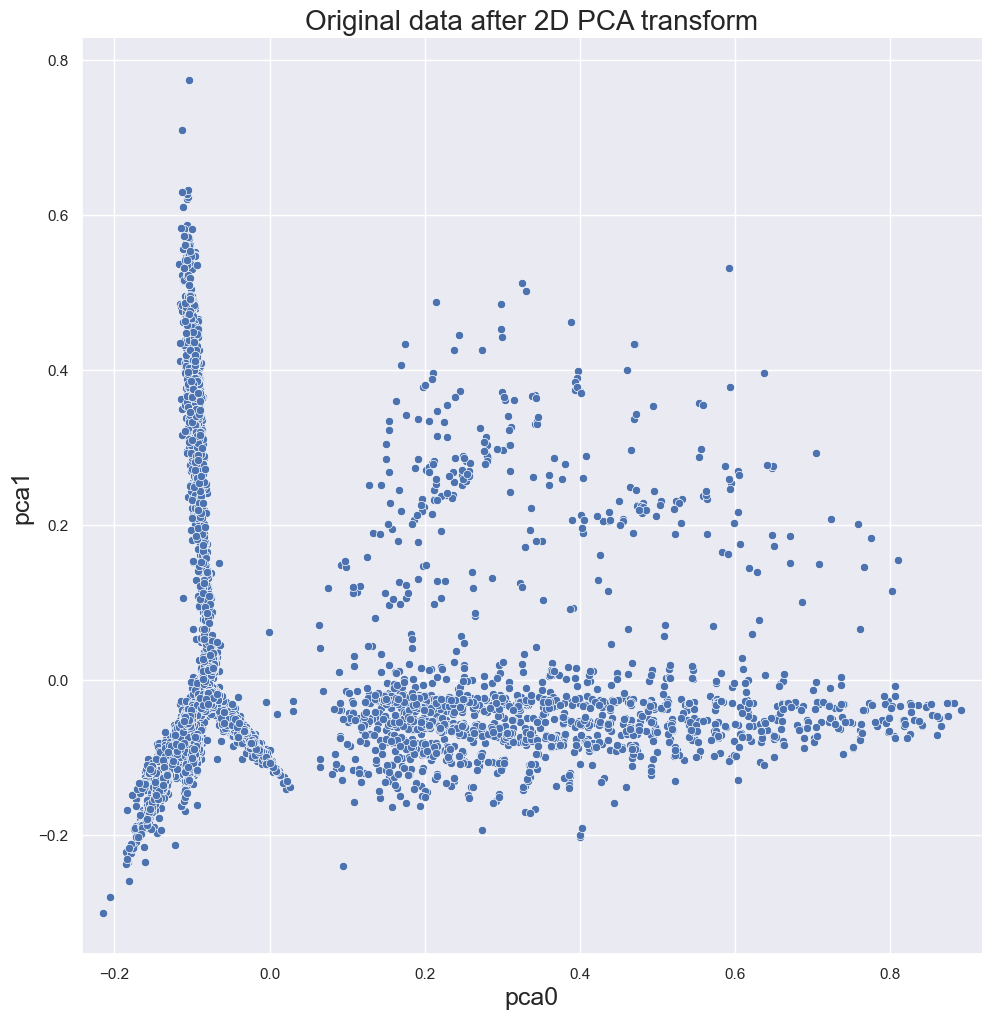

In [16]:
title = 'Original data after 2D PCA transform'
axes_PCA_2D = {'x': 'pca0', 'y': 'pca1'}
Plot2D (sample_PCA_2D, title, axes_PCA_2D)

## Modelación vecinos cercanos

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


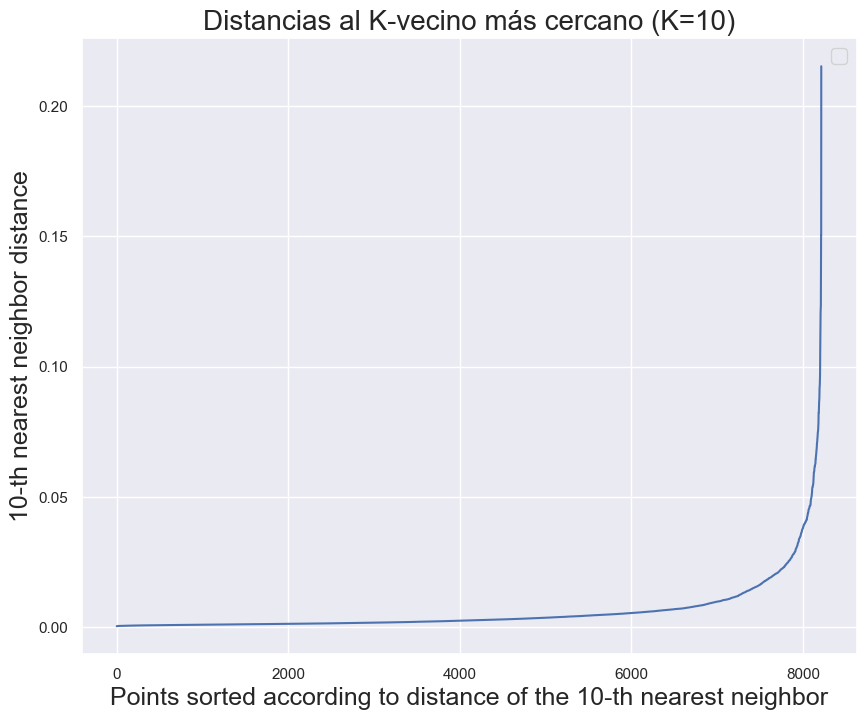

In [17]:
PlotDistancesToKnearestNeighbor(sample_PCA_2D, 10)

## Aplicamos DBScan a los datos

In [18]:
min_samples = 10
epsilon_values = [0.028, 0.03, 0.032, 0.035 , 0.037, 0.04, 0.044, 0.046, 0.05, 0.06]
aux_labels = {}
for epsilon in epsilon_values:
  aux_labels[epsilon] = ApplyDBScanToData (sample_PCA_2D, epsilon, min_samples=min_samples)

epsilon = 0.046
labels_PCA_2D = aux_labels[epsilon]


Test for epsilon = 0.028
Estimated number of clusters: 5
Estimated number of noise points: 220
Silhouette Coefficient: 0.519

Test for epsilon = 0.03
Estimated number of clusters: 5
Estimated number of noise points: 199
Silhouette Coefficient: 0.518

Test for epsilon = 0.032
Estimated number of clusters: 5
Estimated number of noise points: 188
Silhouette Coefficient: 0.520

Test for epsilon = 0.035
Estimated number of clusters: 7
Estimated number of noise points: 148
Silhouette Coefficient: 0.394

Test for epsilon = 0.037
Estimated number of clusters: 8
Estimated number of noise points: 126
Silhouette Coefficient: 0.399

Test for epsilon = 0.04
Estimated number of clusters: 6
Estimated number of noise points: 109
Silhouette Coefficient: 0.413

Test for epsilon = 0.044
Estimated number of clusters: 6
Estimated number of noise points: 92
Silhouette Coefficient: 0.401

Test for epsilon = 0.046
Estimated number of clusters: 6
Estimated number of noise points: 72
Silhouette Coefficient: 0.

## Representación del resultado

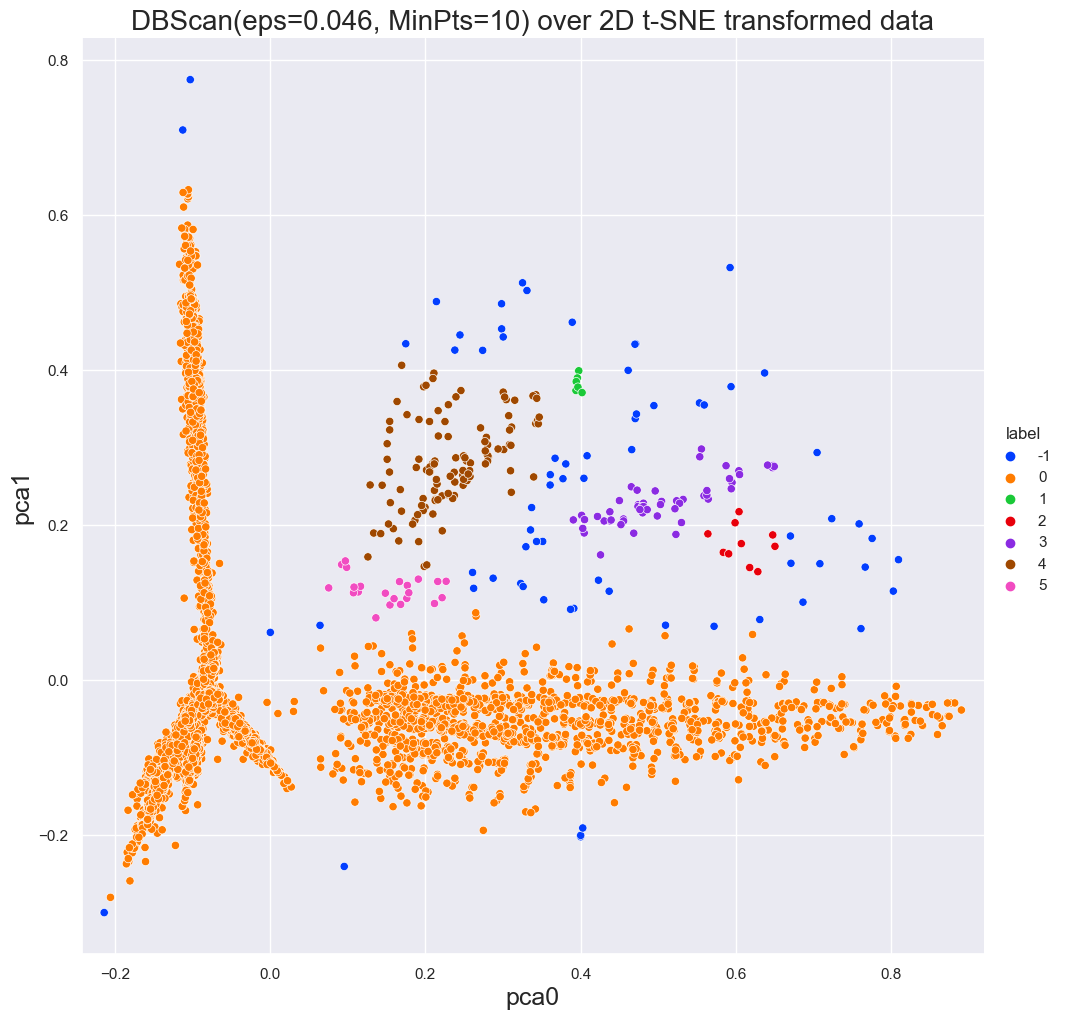

In [19]:
title = f'DBScan(eps={epsilon}, MinPts={min_samples}) over 2D t-SNE transformed data'
Plot2D_WithLabels (sample_PCA_2D, labels_PCA_2D, title, axes_PCA_2D)

## Ahora aplicamos KMeans

In [20]:
#calculo kmeans del texto con aplicar PCA
clusters =[2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
silhouette_avg = []


for i in clusters:
    km = KMeans(n_clusters=i, init='random', max_iter=200, random_state=0).fit(sample_PCA_2D)
    sample_km_pca_2d = km.labels_
    
    score = silhouette_score(sample_PCA_2D, km.labels_)
    silhouette_avg.append(score)
    
    print("cantidad de cluster:", i)
    print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(sample_PCA_2D, sample_km_pca_2d))

C:\Users\mandr\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


cantidad de cluster: 2
Silhouette Coefficient: 0.626


C:\Users\mandr\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


cantidad de cluster: 3
Silhouette Coefficient: 0.712


C:\Users\mandr\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


cantidad de cluster: 4
Silhouette Coefficient: 0.702


C:\Users\mandr\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


cantidad de cluster: 5
Silhouette Coefficient: 0.505


C:\Users\mandr\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


cantidad de cluster: 6
Silhouette Coefficient: 0.522


C:\Users\mandr\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


cantidad de cluster: 7
Silhouette Coefficient: 0.511


C:\Users\mandr\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


cantidad de cluster: 8


C:\Users\mandr\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Silhouette Coefficient: 0.451
cantidad de cluster: 9
Silhouette Coefficient: 0.509


C:\Users\mandr\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


cantidad de cluster: 10
Silhouette Coefficient: 0.516


C:\Users\mandr\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


cantidad de cluster: 11
Silhouette Coefficient: 0.484


C:\Users\mandr\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


cantidad de cluster: 12
Silhouette Coefficient: 0.505


C:\Users\mandr\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


cantidad de cluster: 13
Silhouette Coefficient: 0.500


C:\Users\mandr\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


cantidad de cluster: 14
Silhouette Coefficient: 0.493


C:\Users\mandr\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


cantidad de cluster: 15
Silhouette Coefficient: 0.515


C:\Users\mandr\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


cantidad de cluster: 16
Silhouette Coefficient: 0.511


C:\Users\mandr\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


cantidad de cluster: 17
Silhouette Coefficient: 0.512


C:\Users\mandr\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


cantidad de cluster: 18
Silhouette Coefficient: 0.511


C:\Users\mandr\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


cantidad de cluster: 19
Silhouette Coefficient: 0.512


C:\Users\mandr\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


cantidad de cluster: 20
Silhouette Coefficient: 0.517


## Grafico KMeans 

C:\Users\mandr\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


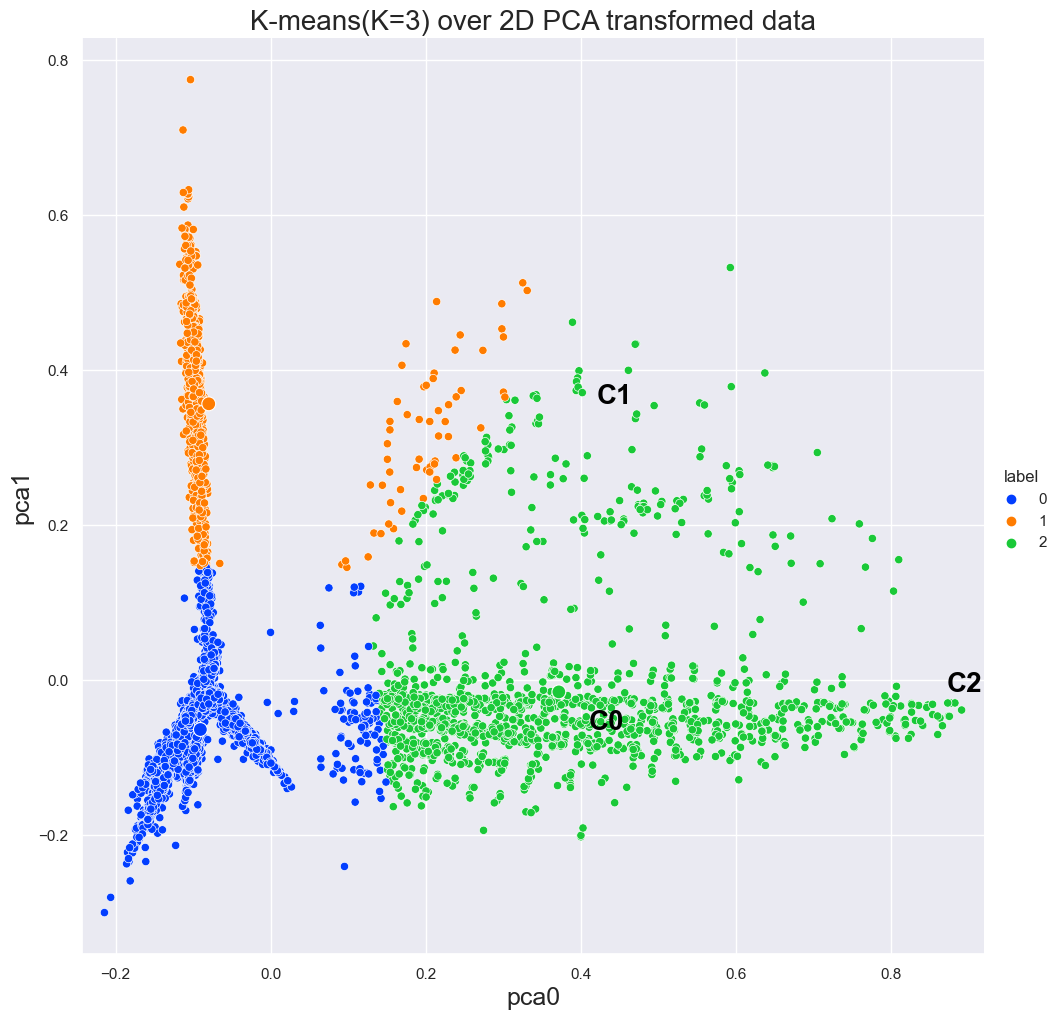

In [21]:
n_clusters = clusters[pd.Series(silhouette_avg).idxmax()]
kmeans = KMeans(n_clusters=n_clusters)
label = kmeans.fit_predict(sample_PCA_2D)

axes_PCA = {'x': 'pca0', 'y': 'pca1'}
title = f'K-means(K={n_clusters}) over 2D PCA transformed data'
plot = Plot2D_WithLabels(sample_PCA_2D, kmeans.labels_, title, axes_PCA, centroids_2D=kmeans.cluster_centers_)

### Reducción por TSNE 2D

## Creación del modelo

In [11]:
tsne2D = TSNE(n_components=2)
samples_TSNE_2D = tsne2D.fit_transform(samples)
df_samples_TSNE_2D = pd.DataFrame(data=samples_TSNE_2D, columns=["tsne0", "tsne1"])

## Representación Visual

C:\Users\mandr\AppData\Local\Temp\ipykernel_11588\737720468.py:14: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.relplot(data=df_samples_2D,


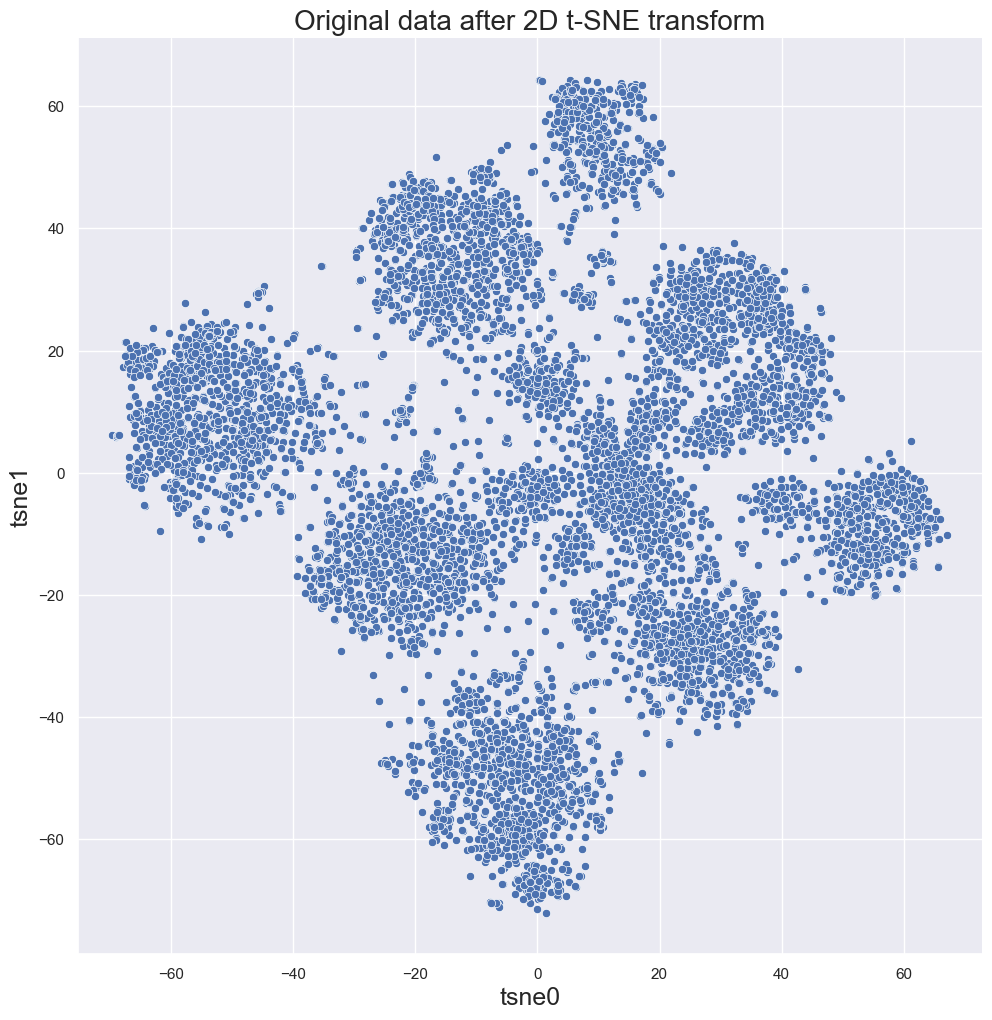

In [12]:
title = 'Original data after 2D t-SNE transform'
axes_TSNE_2D = {'x': 'tsne0', 'y': 'tsne1'}
Plot2D (samples_TSNE_2D, title, axes_TSNE_2D)

## Modelación KnearestNeighbor TSNE 2D

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


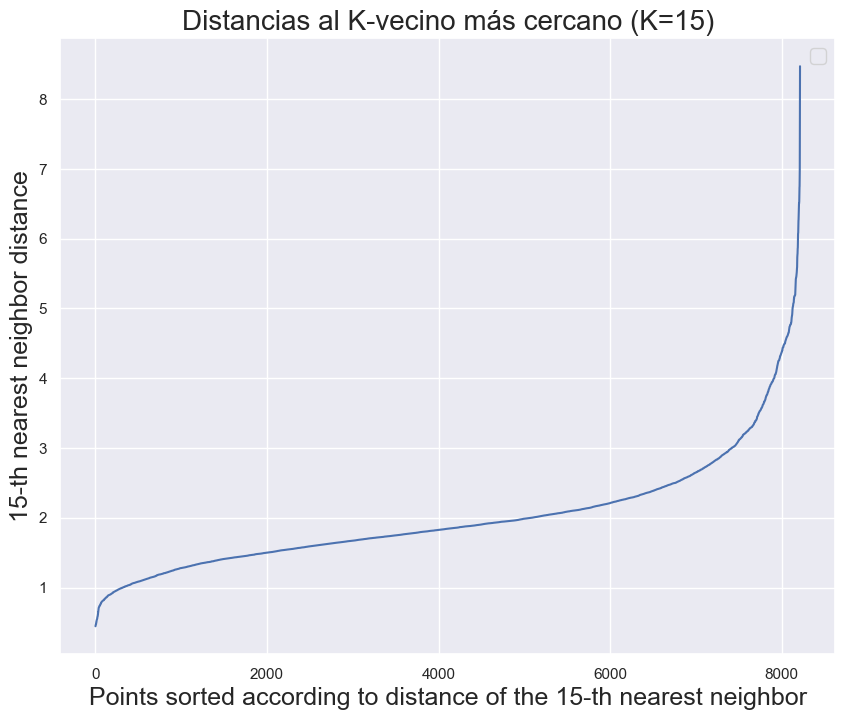

In [24]:
PlotDistancesToKnearestNeighbor(samples_TSNE_2D, 15) # notese que el parametro de entrada NO es samples

### Aplicar KMeans

In [13]:
#calculo kmeans del texto con aplicar PCA
clusters =[2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
silhouette_avg = []


for i in clusters:
    km = KMeans(n_clusters=i, init='random', max_iter=200, random_state=0).fit(samples_TSNE_2D)
    sample_km_pca_2d = km.labels_
    
    score = silhouette_score(samples_TSNE_2D, km.labels_)
    silhouette_avg.append(score)
    
    print("cantidad de cluster:", i)
    print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(samples_TSNE_2D, sample_km_pca_2d))

C:\Users\mandr\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


cantidad de cluster: 2
Silhouette Coefficient: 0.368


C:\Users\mandr\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


cantidad de cluster: 3
Silhouette Coefficient: 0.388


C:\Users\mandr\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


cantidad de cluster: 4
Silhouette Coefficient: 0.423


C:\Users\mandr\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


cantidad de cluster: 5
Silhouette Coefficient: 0.444


C:\Users\mandr\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


cantidad de cluster: 6
Silhouette Coefficient: 0.465


C:\Users\mandr\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


cantidad de cluster: 7
Silhouette Coefficient: 0.486


C:\Users\mandr\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


cantidad de cluster: 8
Silhouette Coefficient: 0.504


C:\Users\mandr\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


cantidad de cluster: 9
Silhouette Coefficient: 0.516


C:\Users\mandr\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


cantidad de cluster: 10
Silhouette Coefficient: 0.509


C:\Users\mandr\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


cantidad de cluster: 11
Silhouette Coefficient: 0.482


C:\Users\mandr\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


cantidad de cluster: 12
Silhouette Coefficient: 0.469


C:\Users\mandr\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


cantidad de cluster: 13
Silhouette Coefficient: 0.433


C:\Users\mandr\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


cantidad de cluster: 14
Silhouette Coefficient: 0.425


C:\Users\mandr\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


cantidad de cluster: 15
Silhouette Coefficient: 0.423


C:\Users\mandr\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


cantidad de cluster: 16
Silhouette Coefficient: 0.408


C:\Users\mandr\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


cantidad de cluster: 17
Silhouette Coefficient: 0.417


C:\Users\mandr\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


cantidad de cluster: 18
Silhouette Coefficient: 0.395


C:\Users\mandr\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


cantidad de cluster: 19
Silhouette Coefficient: 0.407


C:\Users\mandr\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


cantidad de cluster: 20
Silhouette Coefficient: 0.389


## Graficamos KMeans

C:\Users\mandr\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


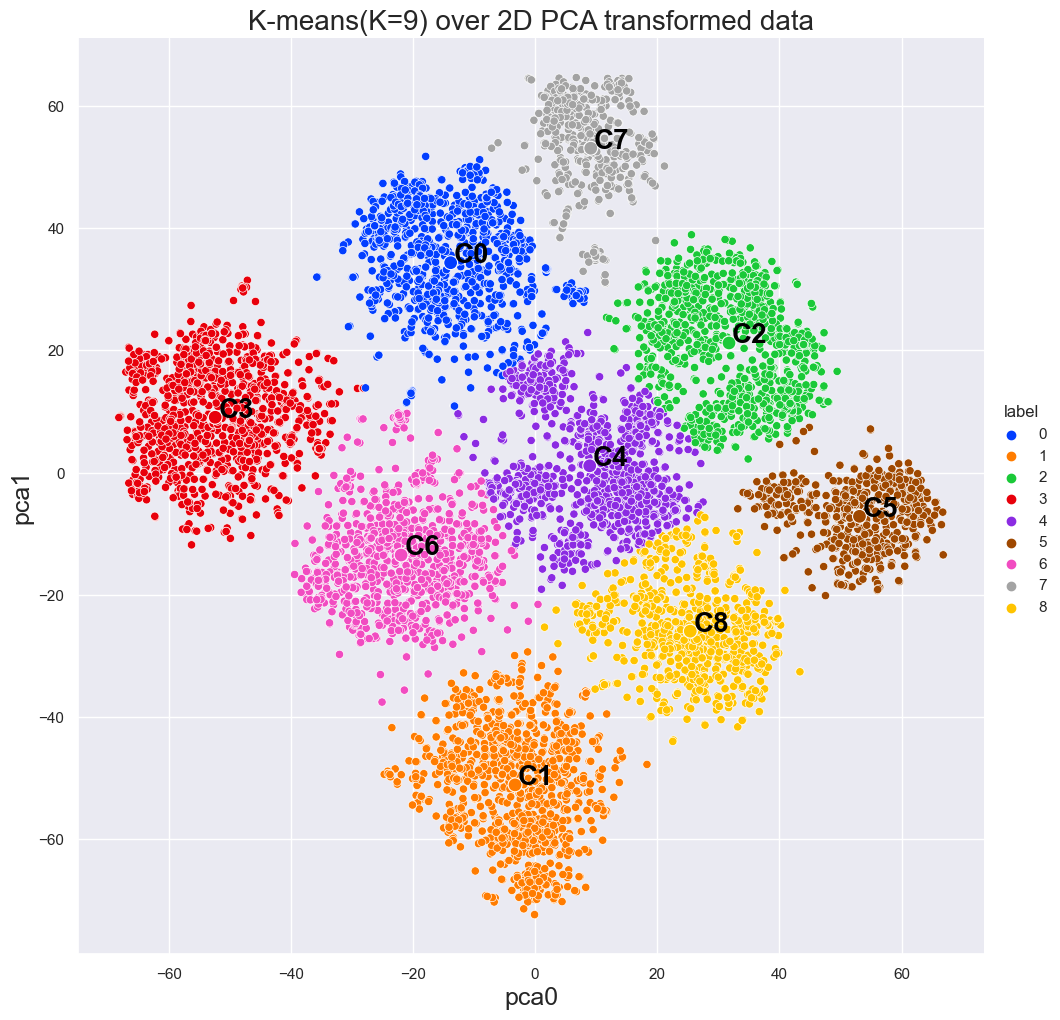

In [26]:
n_clusters = clusters[pd.Series(silhouette_avg).idxmax()]
kmeans = KMeans(n_clusters=n_clusters)
label = kmeans.fit_predict(samples_TSNE_2D)

axes_PCA = {'x': 'pca0', 'y': 'pca1'}
title = f'K-means(K={n_clusters}) over 2D PCA transformed data'
plot = Plot2D_WithLabels(samples_TSNE_2D, kmeans.labels_, title, axes_PCA, centroids_2D=kmeans.cluster_centers_)

## Aplicar DBScan

In [14]:
min_samples = 15
epsilon_values = [3.2, 3.4, 3.6, 3.8, 3.9, 4, 4.05, 4.055,4.1, 4.3, 4.5, 4.7, 4.9]
aux_labels = {}
for epsilon in epsilon_values:
  aux_labels[epsilon] = ApplyDBScanToData (samples_TSNE_2D, epsilon, min_samples=min_samples)

epsilon = 3.4
labels_TSNE_2D = aux_labels[epsilon]


Test for epsilon = 3.2
Estimated number of clusters: 9
Estimated number of noise points: 203
Silhouette Coefficient: -0.090

Test for epsilon = 3.4
Estimated number of clusters: 9
Estimated number of noise points: 173
Silhouette Coefficient: -0.088

Test for epsilon = 3.6
Estimated number of clusters: 6
Estimated number of noise points: 133
Silhouette Coefficient: -0.043

Test for epsilon = 3.8
Estimated number of clusters: 5
Estimated number of noise points: 106
Silhouette Coefficient: -0.200

Test for epsilon = 3.9
Estimated number of clusters: 5
Estimated number of noise points: 90
Silhouette Coefficient: -0.201

Test for epsilon = 4
Estimated number of clusters: 5
Estimated number of noise points: 74
Silhouette Coefficient: -0.205

Test for epsilon = 4.05
Estimated number of clusters: 5
Estimated number of noise points: 71
Silhouette Coefficient: -0.205

Test for epsilon = 4.055
Estimated number of clusters: 5
Estimated number of noise points: 70
Silhouette Coefficient: -0.205

Te

## Representación del resultado

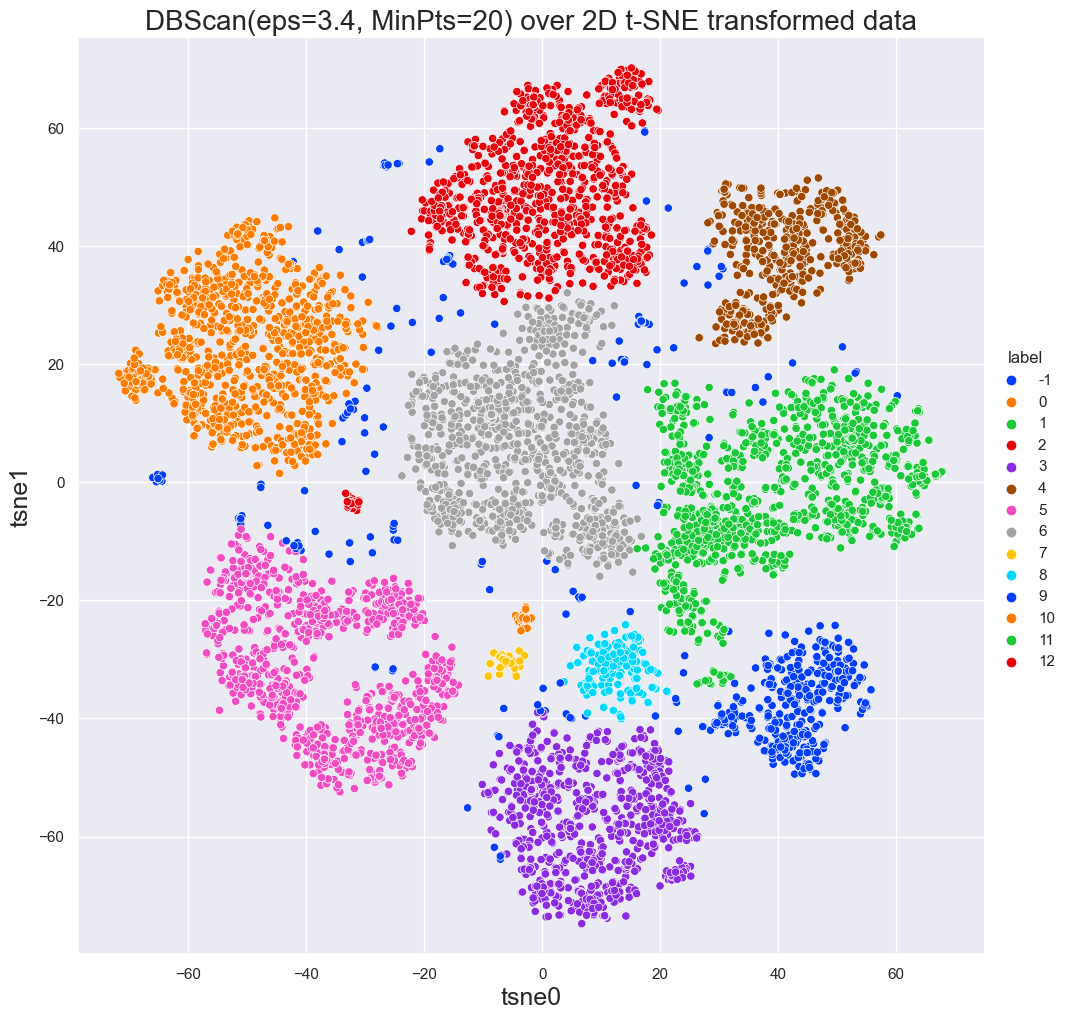

In [56]:
title = f'DBScan(eps={epsilon}, MinPts={min_samples}) over 2D t-SNE transformed data'
Plot2D_WithLabels (samples_TSNE_2D, labels_TSNE_2D, title, axes_TSNE_2D)

## Embeding BETO - MARIA

## Dataset BETO

### Cargado de Datos

In [25]:
dataset2 = np.loadtxt("EmoEvalEs-embeddings-BETO.txt")
dataset2.shape

(8223, 768)

### PCA 2D

##### Búsqueda N° óptimo CLusters

C:\Users\kevin\anaconda3\envs\apau\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



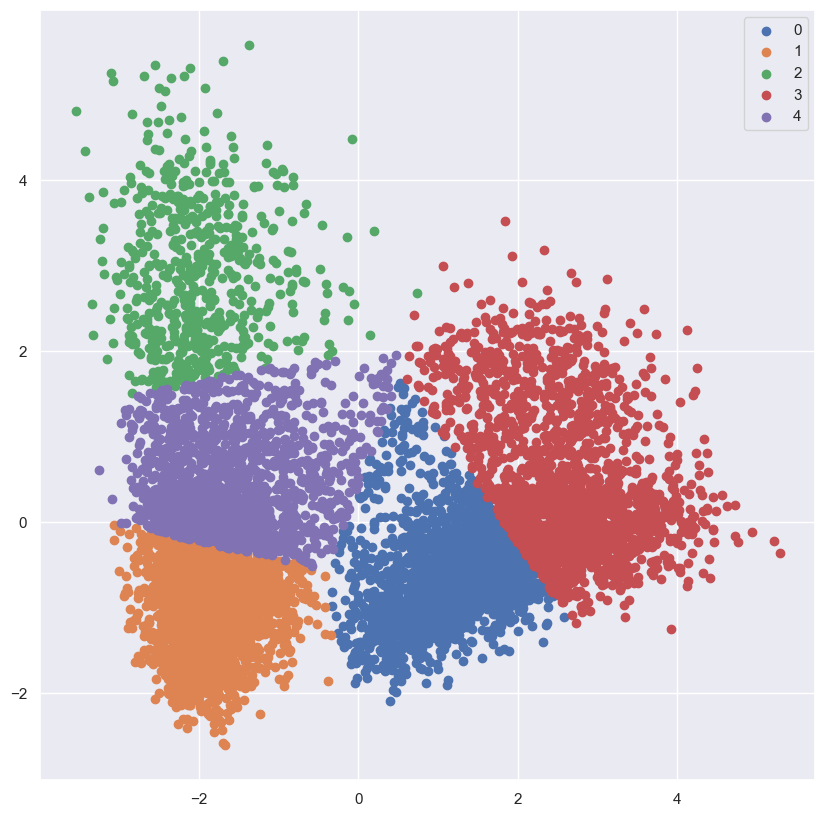

C:\Users\kevin\anaconda3\envs\apau\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



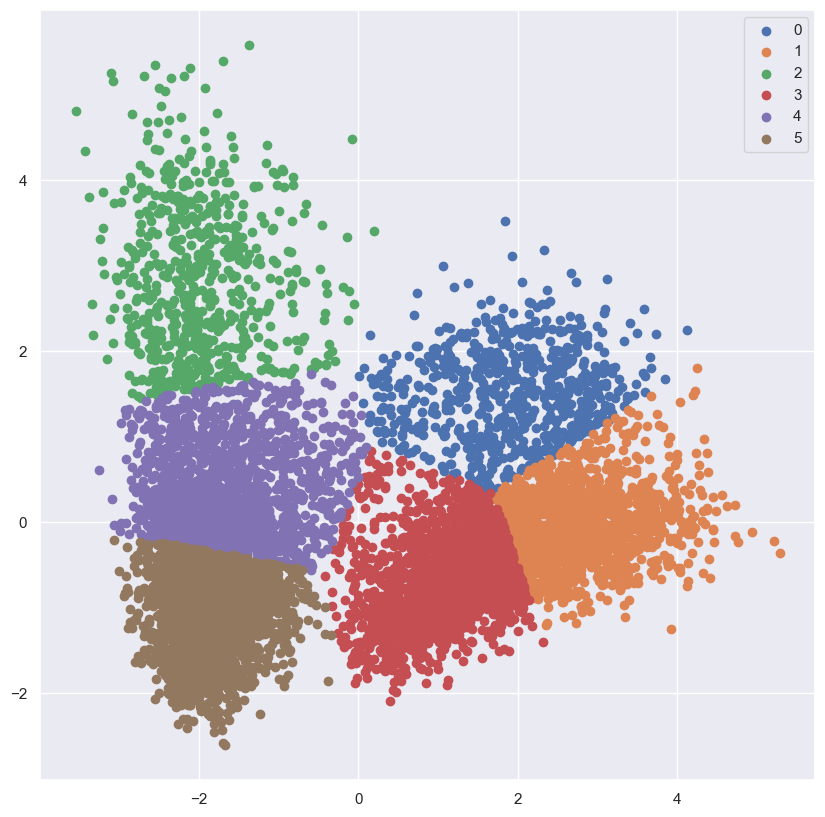

C:\Users\kevin\anaconda3\envs\apau\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



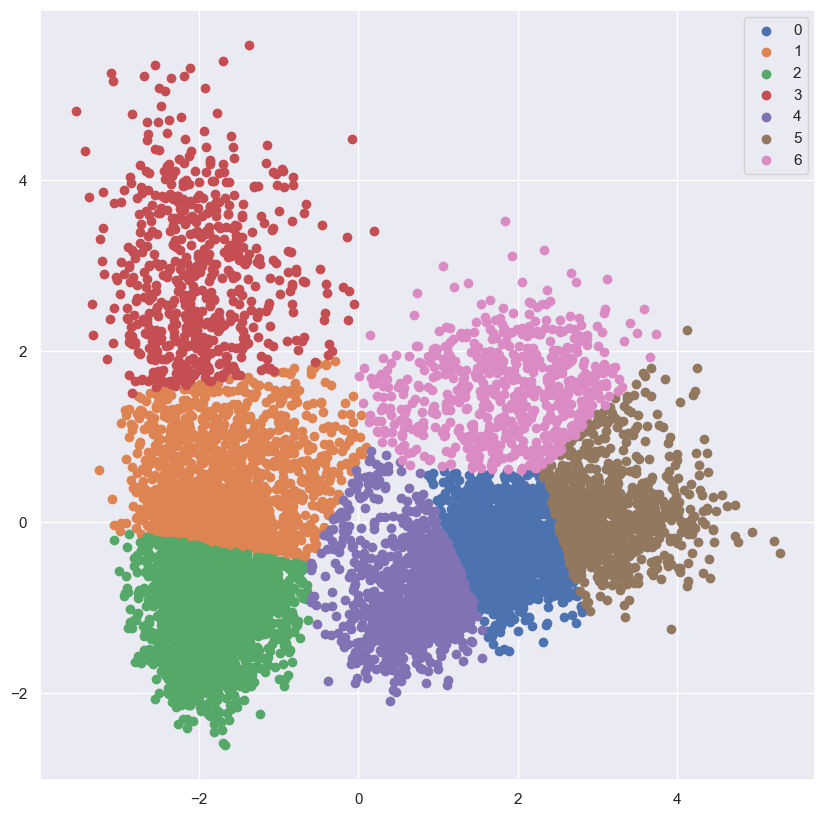

C:\Users\kevin\anaconda3\envs\apau\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



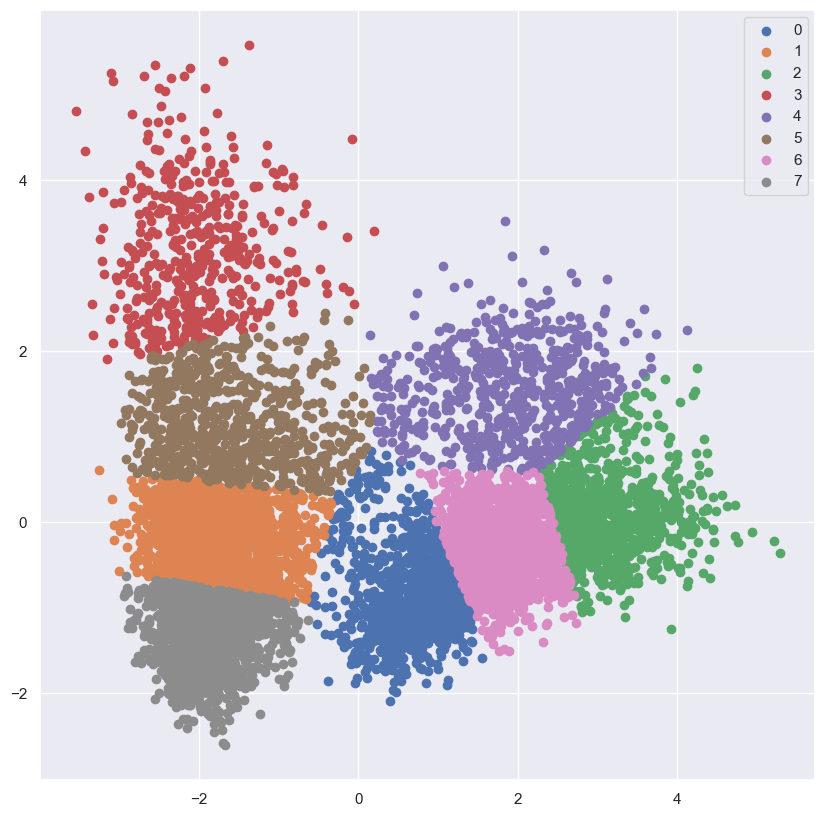

C:\Users\kevin\anaconda3\envs\apau\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



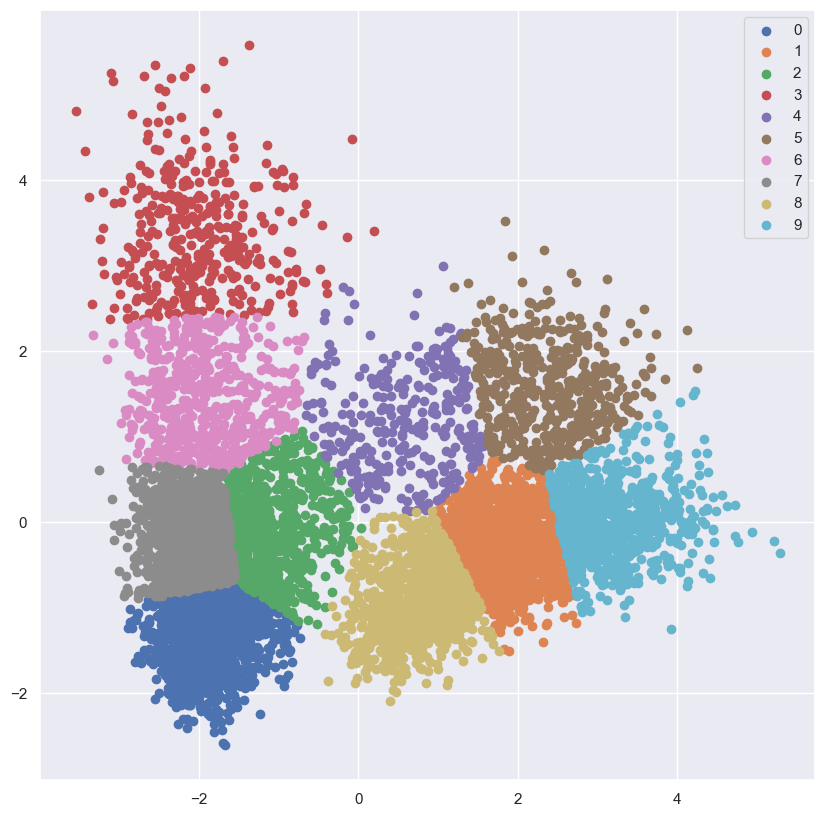

C:\Users\kevin\anaconda3\envs\apau\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



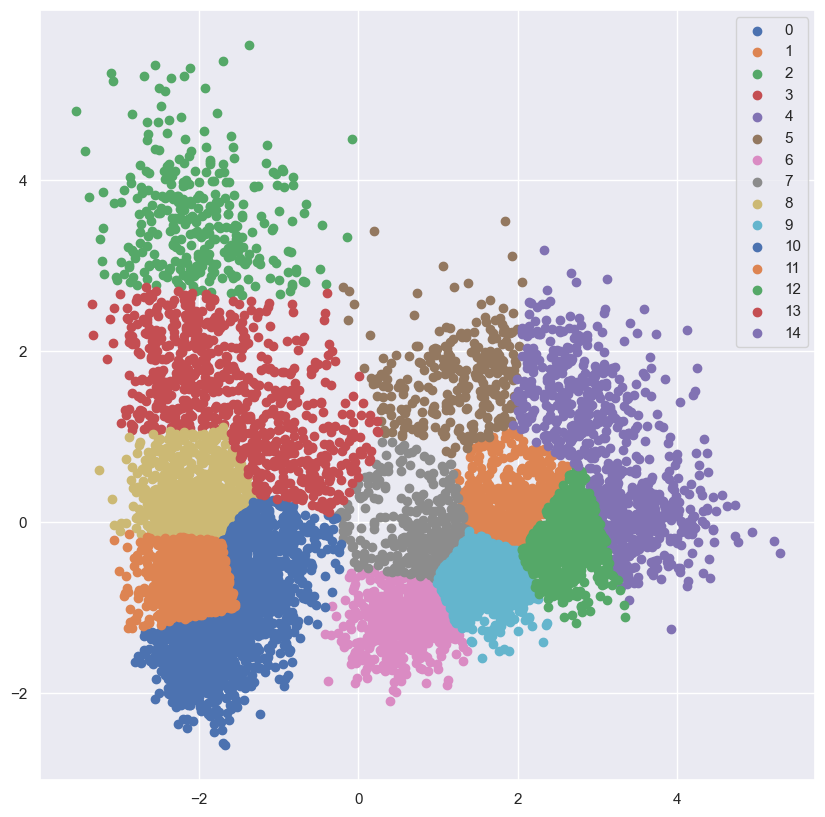

In [225]:
# Raw Data
pca2D = PCA(2)
 
#Transform the data
df_2D = pca2D.fit_transform(dataset2)

df_samples_PCA_2D = pd.DataFrame(data=df_2D, columns=["pca0", "pca1"])

clusters = [5,6,7,8,10,15]
silhouette_avg = []

for i in clusters:
    #Initialize the class object
    kmeans = KMeans(n_clusters=i)
     
    #predict the labels of clusters.
    label = kmeans.fit_predict(df_2D)
     
    #Getting unique labels
    u_labels = np.unique(label)
     
    #plotting the results:
    for i in u_labels:
        plt.scatter(df_2D[label == i , 0] , df_2D[label == i , 1] , label = i)
    plt.legend()
    plt.show()
    
    score = silhouette_score(df_samples_PCA_2D, kmeans.labels_)
    silhouette_avg.append(score)

##### Modelacion N° clusters - Score Silhouette

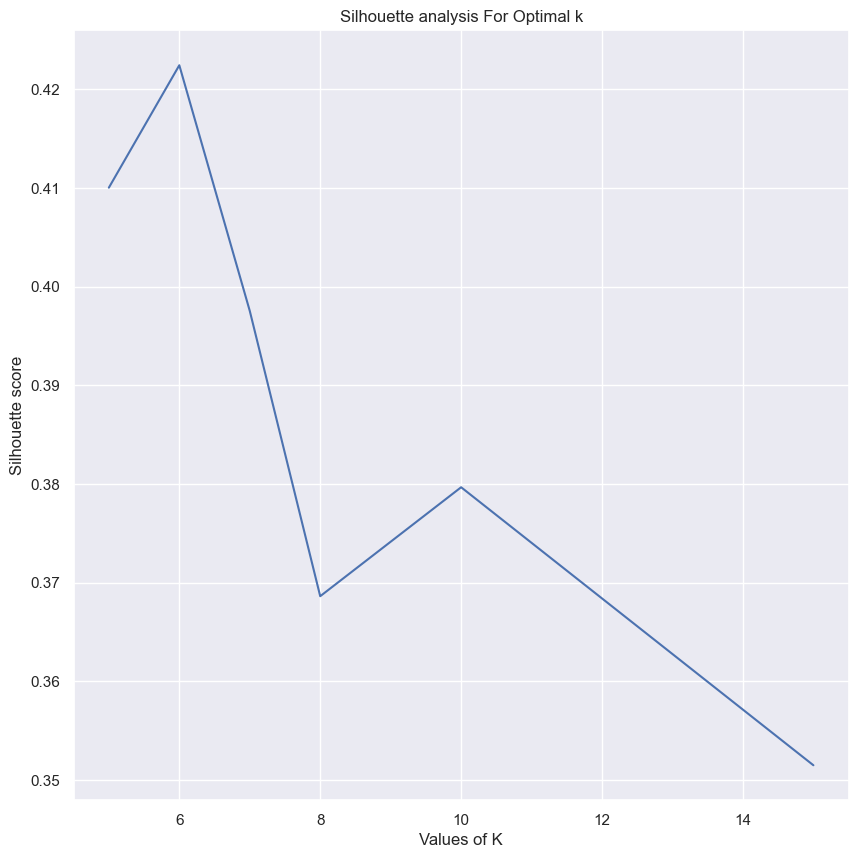

N° Clusters con mejor Score:  6 
Score:  0.422428721441227


In [226]:
plt.plot(clusters,silhouette_avg)
plt.xlabel("Values of K") 
plt.ylabel("Silhouette score") 
plt.title("Silhouette analysis For Optimal k")
plt.show()
print("N° Clusters con mejor Score: ",clusters[pd.Series(silhouette_avg).idxmax()],"\nScore: ",max(silhouette_avg))

##### Modelado K-Means con N° Óptimo Clusters

C:\Users\kevin\anaconda3\envs\apau\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\kevin\AppData\Local\Temp\ipykernel_3392\1757823608.py:49: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



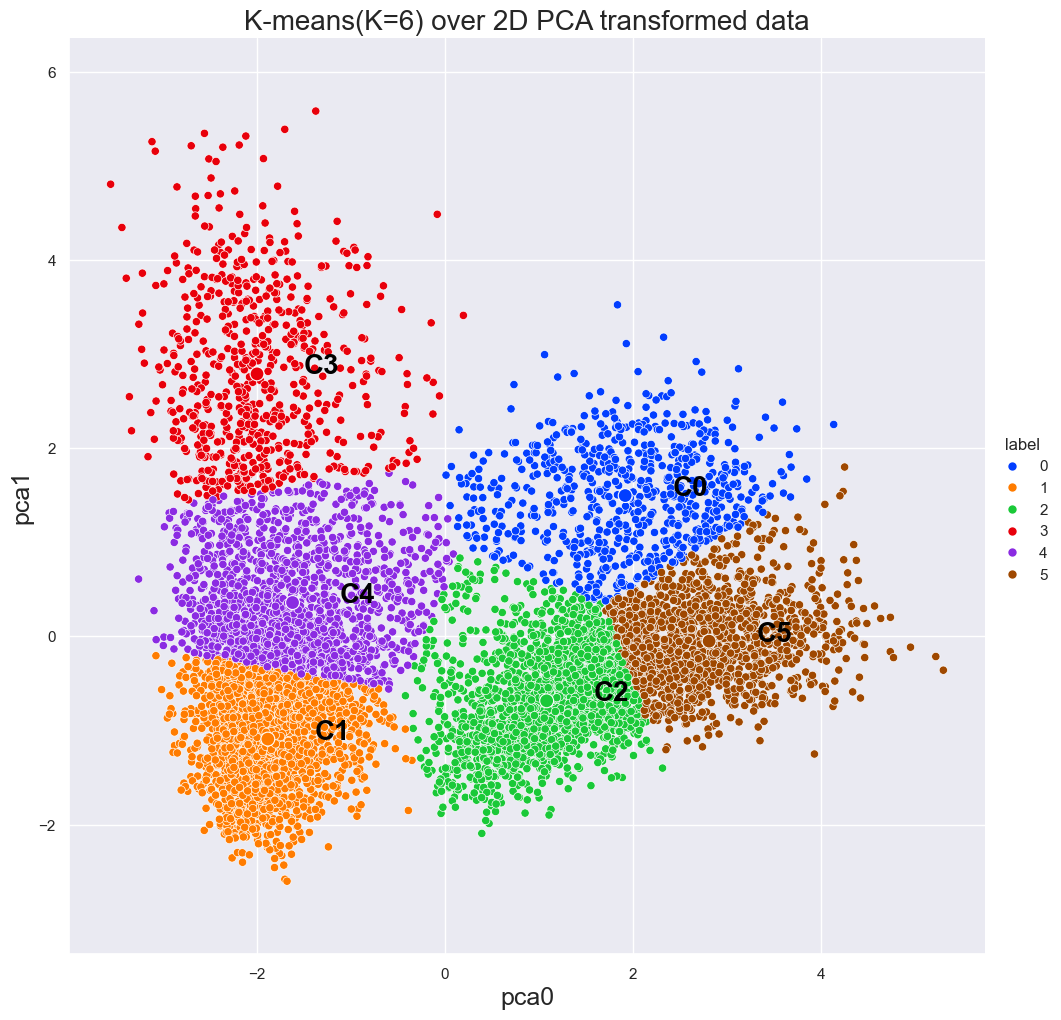

In [228]:
n_clusters = clusters[pd.Series(silhouette_avg).idxmax()]
kmeans = KMeans(n_clusters=n_clusters)
label = kmeans.fit_predict(df_2D)

axes_PCA = {'x': 'pca0', 'y': 'pca1'}
title = f'K-means(K={n_clusters}) over 2D PCA transformed data'
plot = Plot2D_WithLabels(df_2D, kmeans.labels_, title, axes_PCA, centroids_2D=kmeans.cluster_centers_)

### PCA 3D

##### Búsqueda N° óptimo CLusters

C:\Users\kevin\anaconda3\envs\apau\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



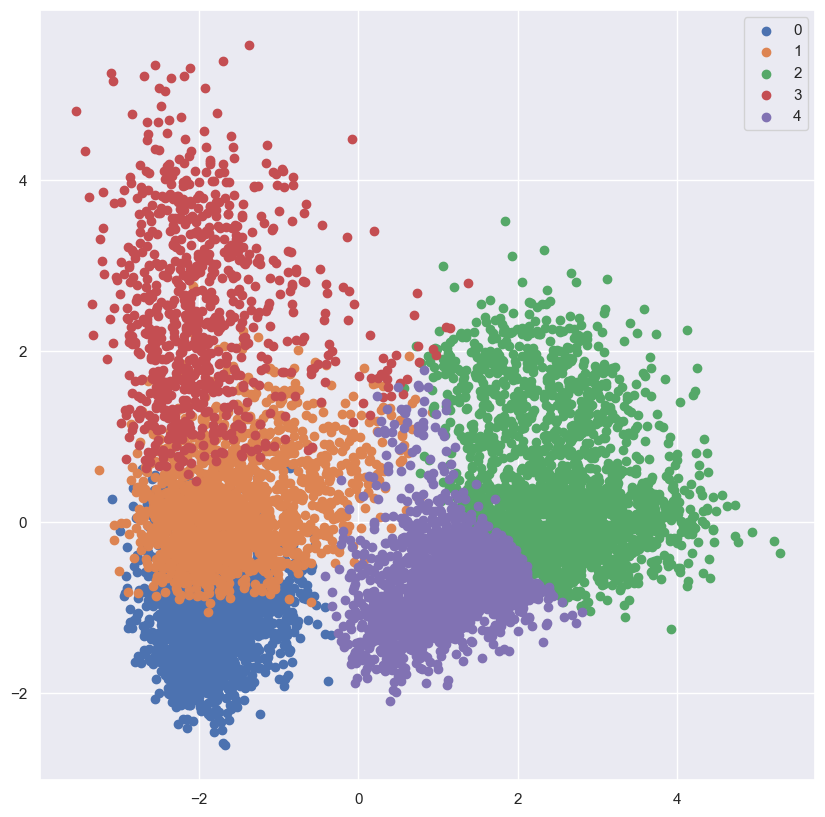

C:\Users\kevin\anaconda3\envs\apau\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



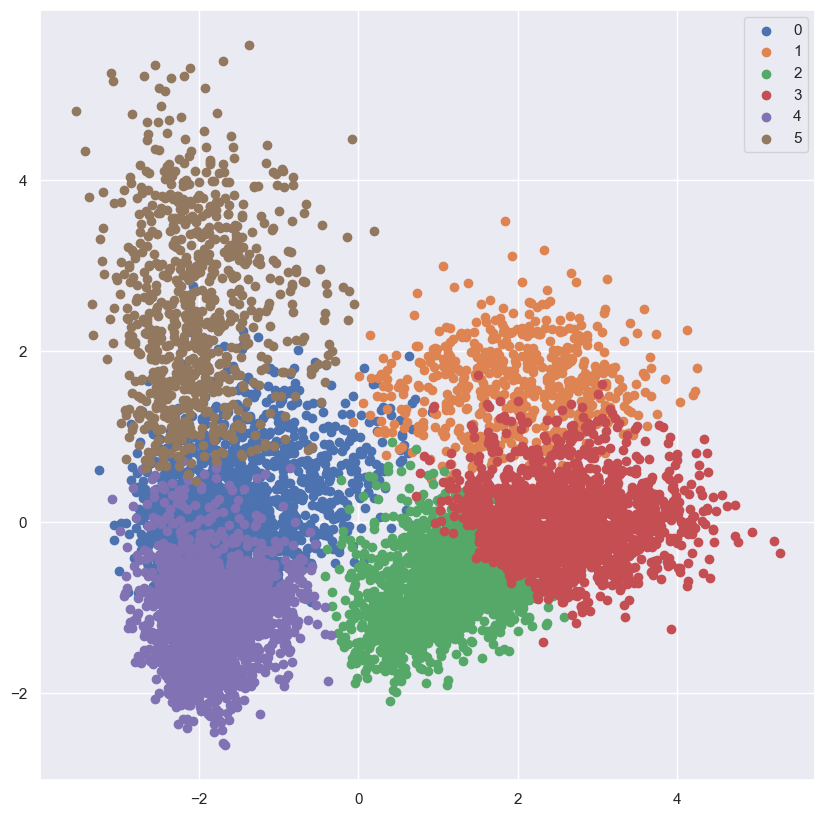

C:\Users\kevin\anaconda3\envs\apau\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



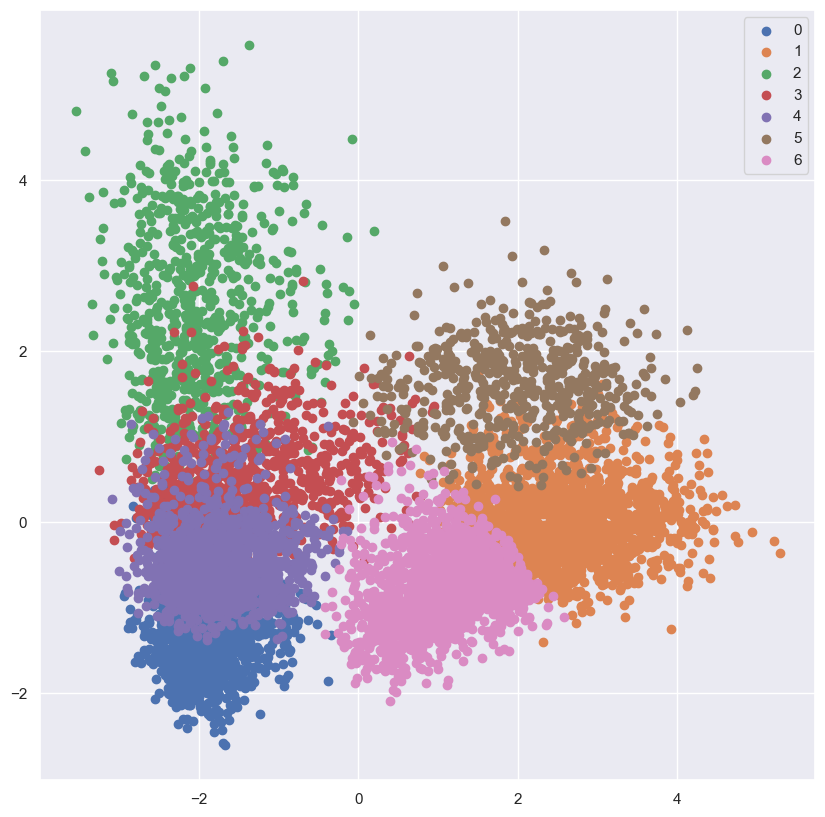

C:\Users\kevin\anaconda3\envs\apau\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



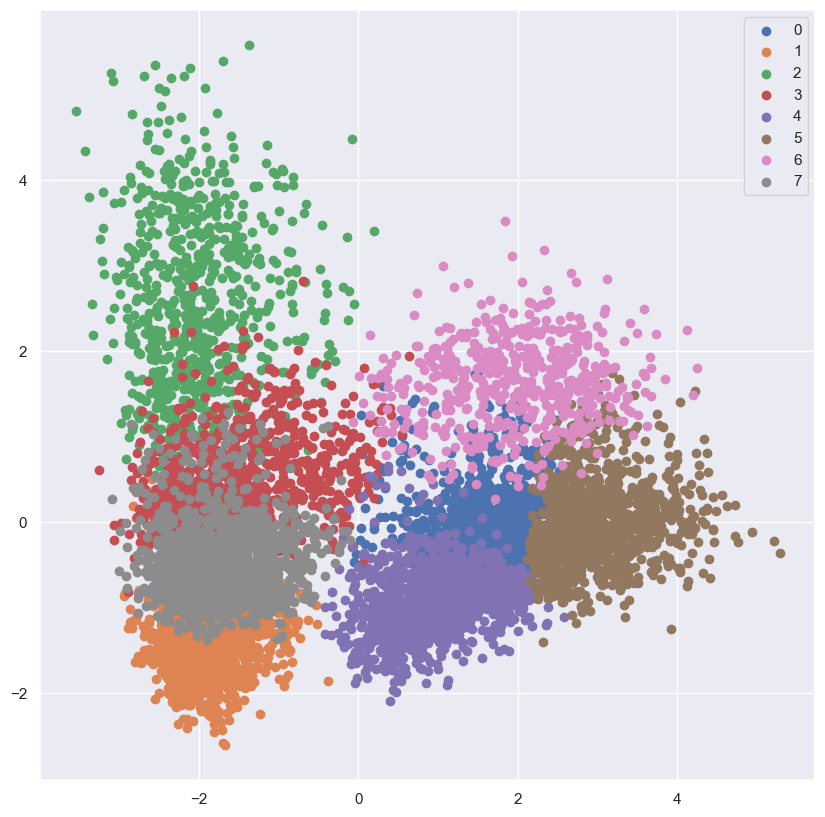

C:\Users\kevin\anaconda3\envs\apau\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



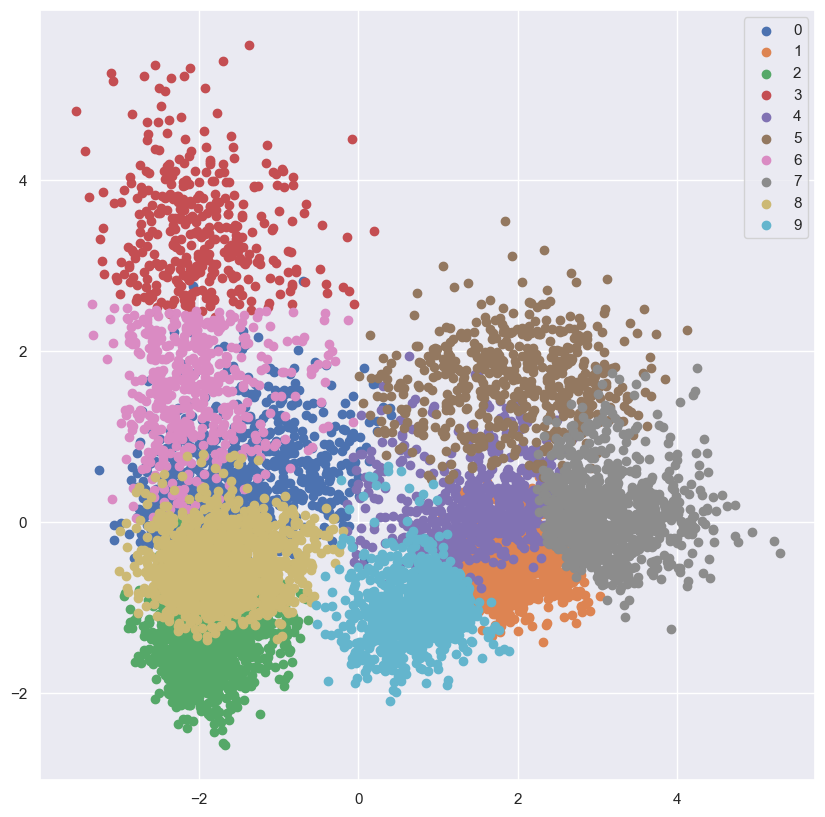

C:\Users\kevin\anaconda3\envs\apau\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



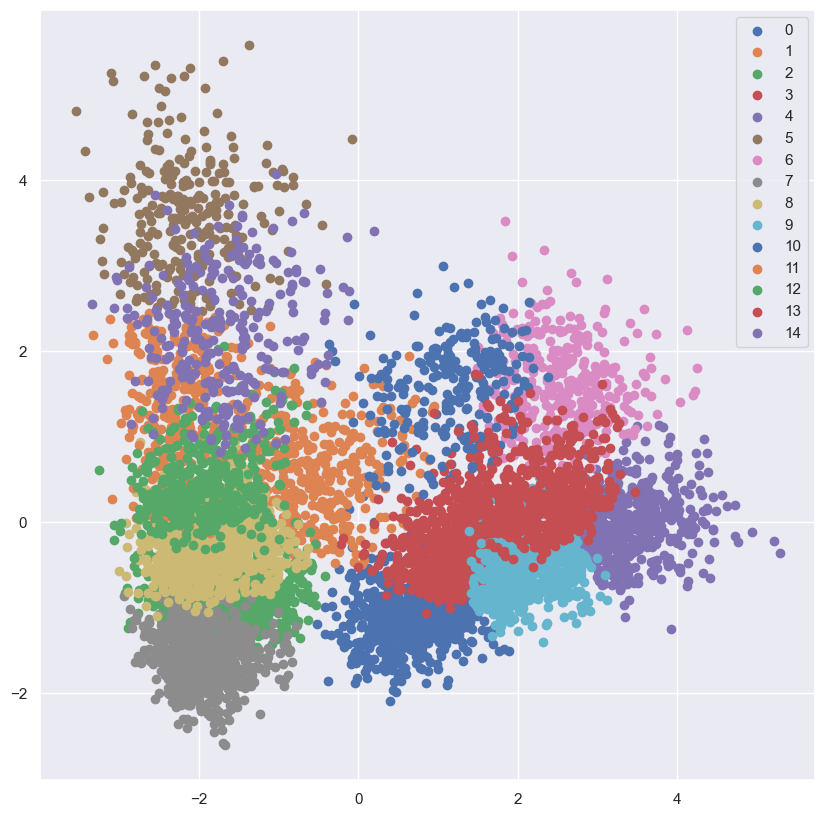

In [229]:
pca3D = PCA(n_components=3)
df_3D = pca3D.fit_transform(dataset2)
df_samples_PCA_3D = pd.DataFrame(data=df, columns=["pca0", "pca1", "pca2"])

clusters = [5,6,7,8,10,15]
silhouette_avg = []

for i in clusters:
    #Initialize the class object
    kmeans = KMeans(n_clusters=i)
     
    #predict the labels of clusters.
    label = kmeans.fit_predict(df_3D)
     
    #Getting unique labels
    u_labels = np.unique(label)
     
    #plotting the results:
    for i in u_labels:
        plt.scatter(df_3D[label == i , 0] , df_3D[label == i , 1] , label = i)
    plt.legend()
    plt.show()
    
    score = silhouette_score(df_samples_PCA_3D, kmeans.labels_)
    silhouette_avg.append(score)

##### Modelacion N° clusters - Score Silhouette

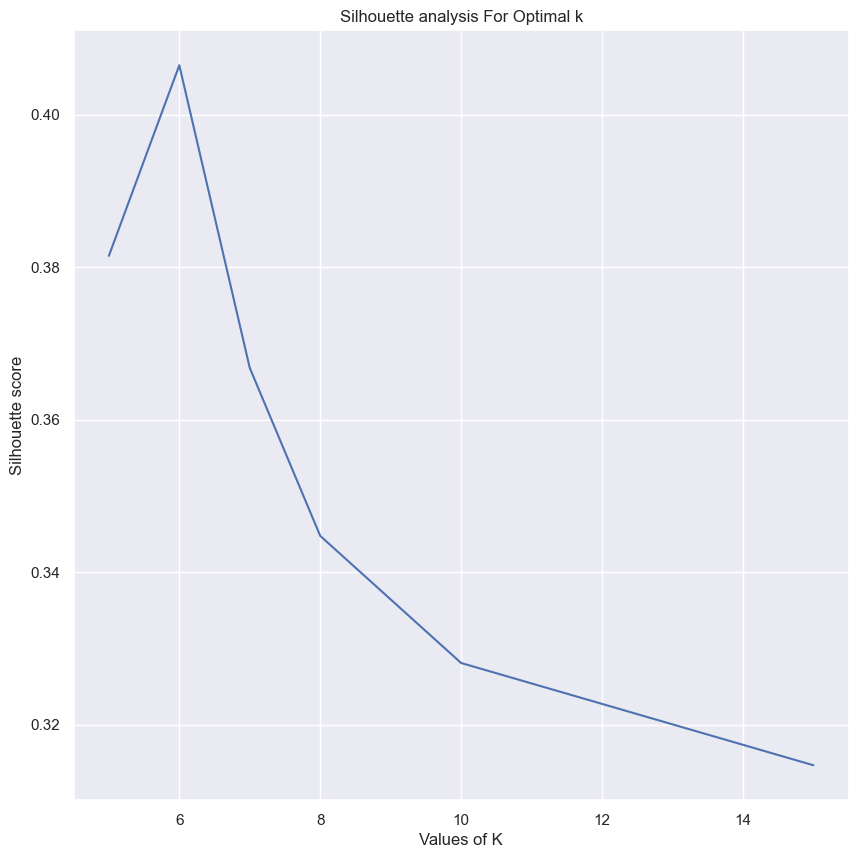

N° Clusters con mejor Score:  6 
Score:  0.4064911374889486


In [230]:
plt.plot(clusters,silhouette_avg)
plt.xlabel("Values of K") 
plt.ylabel("Silhouette score") 
plt.title("Silhouette analysis For Optimal k")
plt.show()
print("N° Clusters con mejor Score: ",clusters[pd.Series(silhouette_avg).idxmax()],"\nScore: ",max(silhouette_avg))

##### Modelado K-Means con N° Óptimo Clusters

C:\Users\kevin\anaconda3\envs\apau\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



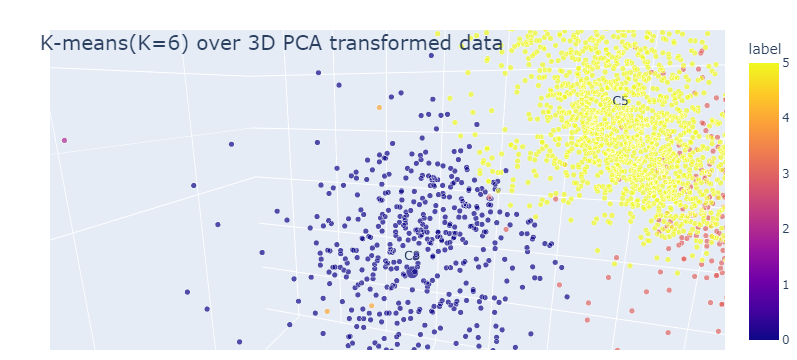

In [231]:
n_clusters = clusters[pd.Series(silhouette_avg).idxmax()]
kmeans = KMeans(n_clusters=n_clusters)
label = kmeans.fit_predict(df_3D)
axes_PCA_3D = {'x': 'pca0', 'y': 'pca1', 'z': 'pca2'}

title = f'K-means(K={n_clusters}) over 3D PCA transformed data'
plot = Plot3D_WithLabels (df_samples_PCA_3D, kmeans.labels_, title, axes_PCA_3D, centroids_3D=kmeans.cluster_centers_)

### DBScan

#### DBScan - PCA 2D

In [ ]:
n_samples = 100
#PlotDistancesToKnearestNeighbor(df_samples_PCA_2D, n_samples)

epsilons = np.linspace(0.1, 5,5)
min_samples_range = range(1, 70,5)

best_eps = None
best_min_samples = None
best_noise_percentage = float('inf')
best_num_clusters = None
score = None

for eps in epsilons:
    for min_samples in min_samples_range:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples, algorithm="ball_tree", metric='minkowski', leaf_size=90, p=8)

        labels = dbscan.fit_predict(df_samples_PCA_2D)

        num_clusters = len(set(labels)) - (1 if -1 in labels else 1)

        noise_percentage = list(labels).count(-1) / len(labels)
        if noise_percentage < best_noise_percentage:
            best_eps = eps
            best_min_samples = min_samples
            best_noise_percentage = noise_percentage
            best_num_clusters = num_clusters
            score = silhouette_score(df_samples_PCA_2D, labels)

print(f"Best Epsilon: {best_eps}")
print(f"Best Min Samples: {best_min_samples}")
print(f"Best Number of Clusters: {best_num_clusters}")
print(f"Best Noise Percentage: {best_noise_percentage}")
print(f"Silhouette Coefficient: {score}")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


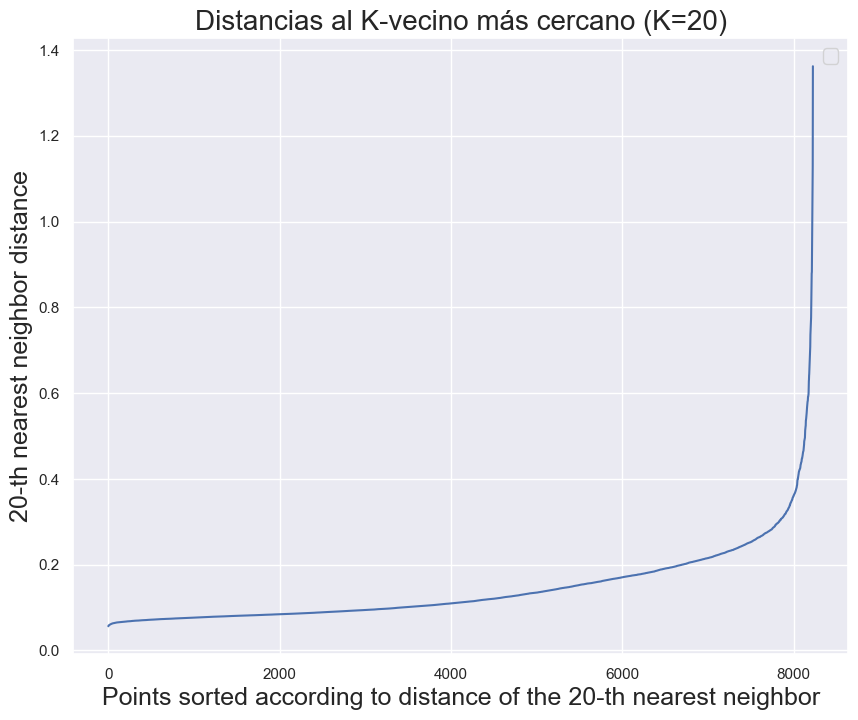

In [354]:
n_samples = 20
PlotDistancesToKnearestNeighbor(df_samples_PCA_2D, n_samples)

#### DBScan - PCA 3D

In [363]:
#db = DBSCAN(eps=1, min_samples=1).fit(df_samples_PCA_3D)

epsis = [0.2,0.3,0.4,0.5,0.6,0.7,0.8]
data_epsis = []
min_samples = 20

for epsilon in epsis:
    db = DBSCAN(eps=epsilon, min_samples=min_samples, algorithm="ball_tree", metric='minkowski', leaf_size=90, p=2).fit(df_samples_PCA_2D)
    labels = db.labels_
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 1)
    n_noise_ = list(labels).count(-1)
    print(f"\nTest for epsilon = {epsilon}")
    print('Estimated number of clusters: %d' % n_clusters_)
    print('Estimated number of noise points: %d' % n_noise_)
    print("Silhouette Coefficient: %0.3f" % silhouette_score(df_samples_PCA_2D, labels))


Test for epsilon = 0.2
Estimated number of clusters: 6
Estimated number of noise points: 780
Silhouette Coefficient: 0.210

Test for epsilon = 0.3
Estimated number of clusters: 1
Estimated number of noise points: 154
Silhouette Coefficient: 0.337

Test for epsilon = 0.4
Estimated number of clusters: 1
Estimated number of noise points: 69
Silhouette Coefficient: 0.376

Test for epsilon = 0.5
Estimated number of clusters: 1
Estimated number of noise points: 26
Silhouette Coefficient: 0.400

Test for epsilon = 0.6
Estimated number of clusters: 1
Estimated number of noise points: 10
Silhouette Coefficient: 0.434

Test for epsilon = 0.7
Estimated number of clusters: 1
Estimated number of noise points: 4
Silhouette Coefficient: 0.438

Test for epsilon = 0.8
Estimated number of clusters: 1
Estimated number of noise points: 1
Silhouette Coefficient: 0.380


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


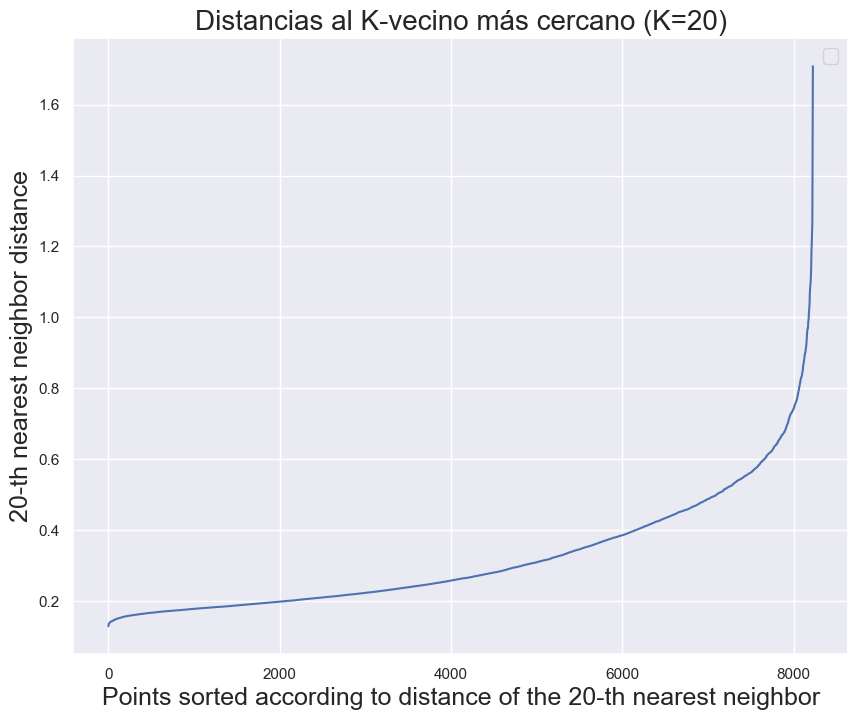

In [359]:
n_samples = 20
PlotDistancesToKnearestNeighbor(df_samples_PCA_3D, n_samples)

In [360]:
#db = DBSCAN(eps=1, min_samples=1).fit(df_samples_PCA_3D)

epsis = [0.2,0.3,0.4,0.5,0.6,0.7,0.9,1]
data_epsis = []
min_samples = n_samples

for epsilon in epsis:
    db = DBSCAN(eps=epsilon, min_samples=min_samples, algorithm="ball_tree", leaf_size=90, p=2).fit(df_samples_PCA_3D)
    labels = db.labels_
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 1)
    n_noise_ = list(labels).count(-1)
    print(f"\nTest for epsilon = {epsilon}")
    print('Estimated number of clusters: %d' % n_clusters_)
    print('Estimated number of noise points: %d' % n_noise_)
    print("Silhouette Coefficient: %0.3f" % silhouette_score(df_samples_PCA_3D, labels))


Test for epsilon = 0.2
Estimated number of clusters: 5
Estimated number of noise points: 4608
Silhouette Coefficient: -0.238

Test for epsilon = 0.3
Estimated number of clusters: 5
Estimated number of noise points: 2326
Silhouette Coefficient: 0.096

Test for epsilon = 0.4
Estimated number of clusters: 7
Estimated number of noise points: 1166
Silhouette Coefficient: 0.208

Test for epsilon = 0.5
Estimated number of clusters: 1
Estimated number of noise points: 395
Silhouette Coefficient: 0.241

Test for epsilon = 0.6
Estimated number of clusters: 1
Estimated number of noise points: 142
Silhouette Coefficient: 0.264

Test for epsilon = 0.7
Estimated number of clusters: 1
Estimated number of noise points: 56
Silhouette Coefficient: 0.325

Test for epsilon = 0.9
Estimated number of clusters: 1
Estimated number of noise points: 7
Silhouette Coefficient: 0.417

Test for epsilon = 1
Estimated number of clusters: 1
Estimated number of noise points: 3
Silhouette Coefficient: 0.406


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


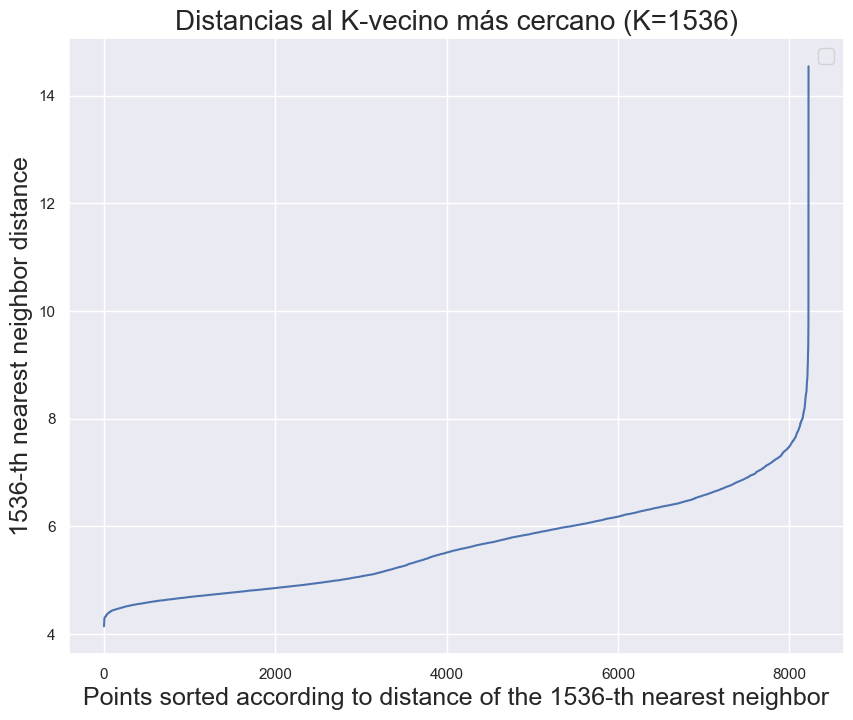

In [142]:
PlotDistancesToKnearestNeighbor(dataset2, 768*2)

#### Dataset MARIA

In [13]:
dataset3 = np.loadtxt("EmoEvalEs-embeddings-MARIA.txt")
print(dataset3)

[[-0.04013521 -0.01157153  0.13377695 ... -0.0769222   0.02230071
  -0.02689679]
 [-0.08612931  0.01868339  0.18985116 ... -0.03398278  0.00411575
  -0.01677153]
 [-0.08364358 -0.02756155  0.13532107 ... -0.01360248  0.05084721
   0.02811539]
 ...
 [-0.02218801 -0.03045888  0.13079686 ... -0.07124317  0.12125146
  -0.03590064]
 [ 0.01607094 -0.12684456  0.10974399 ... -0.08303836  0.04827634
  -0.02457016]
 [ 0.00834936 -0.04697886  0.16302955 ... -0.05958783  0.00384859
  -0.00956425]]


In [14]:
dataset4_BETO = np.load('EmoEvalEs-embeddings-BETO.npy')
dataset4_MARIA = np.load('EmoEvalEs-embeddings-MARIA.npy')

In [15]:
print(dataset4_BETO)

[[-0.30971584  0.07352905 -0.19125856 ... -0.21156345 -0.03232945
   0.29519257]
 [-0.1572928  -0.00081593 -0.0582459  ... -0.5128207   0.01536953
   0.6889545 ]
 [-0.09769987  0.1890629  -0.34290415 ... -0.10073911 -0.11908463
   0.30082774]
 ...
 [-0.22460504  0.02029209 -0.33686748 ... -0.2049038  -0.08248165
   0.29264495]
 [-0.17303307  0.09729547 -0.4695389  ... -0.17773034  0.15084934
   0.16815764]
 [-0.18449457  0.06741171 -0.52664447 ... -0.17114897 -0.06163407
   0.33793235]]


In [16]:
print(dataset4_MARIA)

[[-0.04013521 -0.01157153  0.13377695 ... -0.0769222   0.02230071
  -0.02689679]
 [-0.08612931  0.01868339  0.18985116 ... -0.03398278  0.00411575
  -0.01677153]
 [-0.08364358 -0.02756155  0.13532107 ... -0.01360248  0.05084721
   0.02811539]
 ...
 [-0.02218801 -0.03045888  0.13079686 ... -0.07124317  0.12125146
  -0.03590064]
 [ 0.01607094 -0.12684456  0.10974399 ... -0.08303836  0.04827634
  -0.02457016]
 [ 0.00834936 -0.04697886  0.16302955 ... -0.05958783  0.00384859
  -0.00956425]]
